In [1]:
from __future__ import division

from IPython.display import display

from glob import glob
import pandas as pd
import itertools
import numpy as np
from scipy.stats import mannwhitneyu, wilcoxon, chisquare
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

%matplotlib inline

# convienence functions
def make_barchart(series):
    means = [i.mean() for i in series]
    errors = ([0]*len(series),[i.std()/np.sqrt(len(i)) for i in series])
    inds = range(len(series))
    plt.bar(xrange(0,3), means, align='center', yerr=errors)
    plt.xticks(xrange(0,3), ('Palm', 'Stool', 'Tongue'))

# adapted from http://stackoverflow.com/questions/33873176/how-to-add-significance-levels-on-bar-graph-using-pythons-matplotlib
def significance_bar(start, end, height, displaystring, linewidth = 1, markersize = 2, fontsize = 15, color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end], [height]*2, '-', color = color, lw=linewidth, marker = TICKDOWN, markeredgewidth=linewidth, markersize = markersize)
#     plt.plot([start,end], [height]*2, '-', color = color, lw=linewidth)
    # draw the text
    plt.text(0.5*(start+end), height+.001, displaystring, ha ='center', va='center', size = fontsize)

def get_specificity(contribs, meta):
    contrib_ind = meta.loc[contribs.name, 'anonymized_name']
    contrib_family = meta.loc[contribs.name, 'family']
    specificity = list()
    for i in contribs.index:
        if 'unknown' in i.lower():
            specificity.append('Unknown')
            continue
        curr_family = meta.loc[i, 'family']
        curr_ind = meta.loc[i, 'anonymized_name']
        if curr_ind == contrib_ind:
            specificity.append('Self')
        elif curr_family == contrib_family:
            specificity.append('Family')
        else:
            specificity.append('Unrelated')
    return specificity

# read in data
full_meta = pd.read_table("data/797_prep_296_qiime_20150818-225202.txt", index_col=0)
results = pd.read_table("data/full_results.txt", index_col=0)
# sync meta with results
meta = full_meta.loc[results.index+results.columns]
# read in standard deviations
results_std = pd.read_table("data/full_results_std.txt", index_col=0)
results_var = np.square(results_std)
# sort indicies so we are all in the same order
meta = meta.sort_index()
results = results.sort_index()
results_std = results_std.sort_index()

# random globals
vert_offset = 1/6.

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/ipykernel/__main__.py:57: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()


# Analysis of SourceTracker Results for Analysis of Song et al. 2013

This includes all analysis used to generate numbers and figures from Shaffer et al. 2017. Generation and analysis of spike-in experiments is provided in the spikeins folder of this repository.

## Very basic summary numbers

We will start with a basic summary of the individuals that have been included in the study.

In [2]:
print "Number of familes: %s" % len(set(meta.family))
print "Number of individuals: %s" % len(set(meta.anonymized_name))
print "Number of samples: %s" % meta.shape[0]
print "Number of palms: %s" % results.shape[0]
print "Number of sources: %s" % results.shape[1]

Number of familes: 73
Number of individuals: 172
Number of samples: 809
Number of palms: 305
Number of sources: 504


## Validation

So first we want to validate that we are actually seeing higher levels of mapping of OTUs to self and family samples more than expected by chance.

In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

r_base = importr('base')
r_stats = importr('stats')

columns = ["in_fam", "abundance", "pred_abundance", "sink"]

def get_abundance(results, meta):
    columns = ["in_fam", "abundance", "pred_abundance", "sink"]
    self = list()
    in_family = list()
    outside_family = list()
    for fam in set(meta.family):
        fam02 = results.loc[meta.family==fam, results.columns[:-1]]
        fam02_inds = set(meta.loc[fam02.index, "anonymized_name"])
        for title1, row1 in fam02.iterrows():
            for title2, value in row1.iteritems():
                if title2 == "Unknown":
                    print "Unknown"
                    continue
                elif meta.loc[title2, "anonymized_name"] == meta.loc[title1, "anonymized_name"]:
                    self.append(value)
                elif meta.loc[title2, "anonymized_name"] in fam02_inds:
                    in_family.append(value)
                else:
                    outside_family.append(value)
    return self, in_family, outside_family

So in the cell below we create a dataframe where source and sink sample combination is labelled by whether or not the source was from the self or a family member realitve to the sink. This allows us to find our true distributions to compare to distributions where reads are randomly assigned to samples.

In [4]:
samples_all = list()
to_plot_rows = list()

for fam in set(meta.family):
    fam02 = results.loc[meta.family==fam, results.columns[:-1]]
    fam02_inds = set(meta.loc[fam02.index, "anonymized_name"])
    for title1, row1 in fam02.iterrows():
        pred_count = row1.sum()/row1.shape[0]
        to_test_rows = list()
        for title2, value in row1.iteritems():
            if meta.loc[title2, "anonymized_name"] == meta.loc[title1, "anonymized_name"]:
                in_fam = "self"
            elif meta.loc[title2, "anonymized_name"] in fam02_inds:
                in_fam = "family"
            else:
                in_fam = "out"
            to_plot_rows.append((in_fam, value, pred_count, title2))
            to_test_rows.append((in_fam, value*1000, pred_count*1000, title2))
        to_test = pd.DataFrame(to_test_rows, columns=columns)
        array = to_test.groupby(to_test.in_fam).sum().reindex(['self', 'family', 'out']).values
        samples_all.append(np.nan_to_num(array))

to_plot_all = pd.DataFrame(to_plot_rows, columns=columns)
samples_all = np.asarray(samples_all)
display(to_plot_all.head())

,in_fam,abundance,pred_abundance,sink
0,out,0.0,0.001804,797.02.HA.Forehead
1,out,0.0,0.001804,797.02.HA.Stool
2,out,0.0,0.001804,797.02.HA.Tongue
3,out,0.0,0.001804,797.02.HB.Forehead
4,out,0.0,0.001804,797.02.HB.Stool


This is a histogram of the above data which is figure 1C in the manuscript. Here we can see that there are source, sink combinations which are mappings from the self which represent a large proportion of a single source. Almost all outside family mappings are 0% for a given sample.

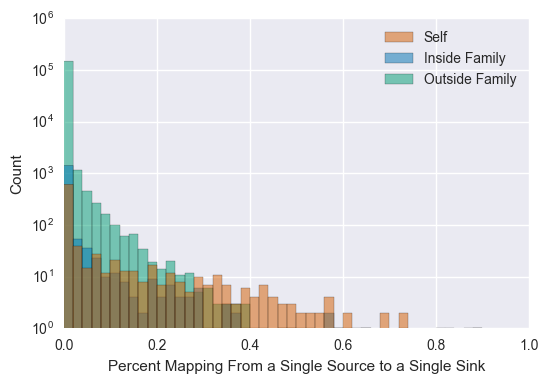

In [5]:
bins = np.linspace(0, 1, 51)
colors = sns.color_palette("colorblind", 3)
plt.hist(to_plot_all["abundance"][to_plot_all.in_fam == "out"], log=True, label="Outside Family", bins=bins, alpha=.5, color=colors[1])
plt.hist(to_plot_all["abundance"][to_plot_all.in_fam == "family"], log=True, label="Inside Family", bins=bins, alpha=.5, color=colors[0])
plt.hist(to_plot_all["abundance"][to_plot_all.in_fam == "self"], log=True, label="Self", bins=bins, alpha=.5, color=colors[2])
_ = plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles[::-1], labels[::-1])
_ = plt.xlabel("Percent Mapping From a Single Source to a Single Sink")
_ = plt.ylabel("Count")
plt.savefig('figures/fig1C.png', dpi=500, bbox_inches="tight")

So to test that mapping to self, in family and out family are happening at rates different from if reads were randomly assigned per sink we use the Cochran-Mantel-Haenszel test as implemented in R. This is essentially a chi squared test where there are multiple samples. The p-value of zero indicates that the distribution of samples mapping to self, family and outside of the family compared to a distribution where each read per sample was assigned randomly is significantly different.

In [6]:
to_plot_all_grouped = to_plot_all.groupby(to_plot_all.in_fam).sum().reindex(['self', 'family', 'out'])
display(to_plot_all_grouped)
test_all = r_stats.mantelhaen_test(samples_all.transpose([1,2,0]))
print test_all.rx2('p.value')

,abundance,pred_abundance
in_fam,,
self,60.7136,1.716819
family,26.1268,3.109095
out,206.2484,288.262885


[1] 0



Now to visualize the difference we simulated random assignment of reads to each sample and then determined the number that mapped to self, family and outside family as before.

In [7]:
perms = 25
bin_centers = (bins[1:] + bins[:-1]) / 2
perms_self = pd.DataFrame(index=bin_centers)
perms_in_family = pd.DataFrame(index=bin_centers)
perms_out_family = pd.DataFrame(index=bin_centers)

for i in xrange(perms):
    # do permutation
    results_perm = results.copy()
    columns_perm = results_perm.columns
    new_column_order = np.random.choice(columns_perm[:-1], len(columns_perm)-1, replace=False)
    results_perm = results_perm[list(new_column_order)+["Unknown"]]
    results_perm.columns = results.columns
    self, in_family, out_family = get_abundance(results_perm, meta)
    self_bins, self_bin_edges = np.histogram(self, bins=bins)
    perms_self[i] = self_bins
    in_family_bins, in_family_bin_edges = np.histogram(in_family, bins=bins)
    perms_in_family[i] = in_family_bins
    out_family_bins, out_family_bin_edges = np.histogram(out_family, bins=bins)
    perms_out_family[i] = out_family_bins

And then we plotted the averages of these permutations. This shows how much would be expected to map to outside the family by chance. Relative to the plot of the real data we can see how often self and inside family mappings were present realtive to outside family mappings.

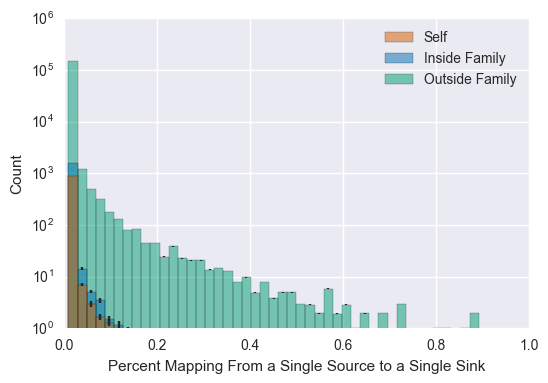

In [8]:
perms_out_family.mean(axis=1).plot(kind='bar', log=True, yerr=perms_out_family.sem(axis=1), color=colors[1], alpha=.5, width=1, xlim=(0,1), ylim=(1, 1000000), label="Outside Family")
perms_in_family.mean(axis=1).plot(kind='bar', log=True, yerr=perms_in_family.sem(axis=1), color=colors[0], alpha=.5, width=1, xlim=(0,1), ylim=(1, 1000000), label="Inside Family")
perms_self.mean(axis=1).plot(kind='bar', log=True, yerr=perms_self.sem(axis=1), color=colors[2], alpha=.5, width=1, xlim=(0,1), ylim=(1, 1000000), label="Self")
_ = plt.legend()
_ = plt.xticks(np.linspace(-1, 50, 6), np.linspace(0, 1, 6), rotation=0, ha='center')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles[::-1], labels[::-1])
_ = plt.xlabel("Percent Mapping From a Single Source to a Single Sink")
_ = plt.ylabel("Count")
plt.savefig('figures/fig1D.png', dpi=500, bbox_inches="tight")

So now let's break down this data per source site and see if the patterns persist.

### Stool only

In [9]:
samples_stool = list()
to_plot_rows = list()

results_stool = results[[i for i in results.columns if "stool" in i.lower()]]
columns = ["in_fam", "abundance", "pred_abundance", "sink"]
for fam in set(meta.family):
    fam02 = results_stool.loc[meta.family==fam]
    fam02_inds = set(meta.loc[fam02.index, "anonymized_name"])
    for title1, row1 in fam02.iterrows():
        pred_count = row1.sum()/row1.shape[0]
        to_test_rows = list()
        for title2, value in row1.iteritems():
            if title2 == "Unknown":
                print "Unknown"
                continue
            elif meta.loc[title2, "anonymized_name"] == meta.loc[title1, "anonymized_name"]:
                in_fam = "self"
            elif meta.loc[title2, "anonymized_name"] in fam02_inds:
                in_fam = "family"
            else:
                in_fam = "out"
            to_plot_rows.append((in_fam, value, pred_count, title2))
            to_test_rows.append((in_fam, value*1000+1, pred_count*1000+1, title2))
        to_test = pd.DataFrame(to_test_rows, columns=columns)
        array = to_test.groupby(to_test.in_fam).sum().reindex(['self', 'family', 'out']).values
        samples_stool.append(np.nan_to_num(array))

to_plot_stool = pd.DataFrame(to_plot_rows, columns=columns)
samples_stool = np.asarray(samples_stool).transpose([1,2,0])

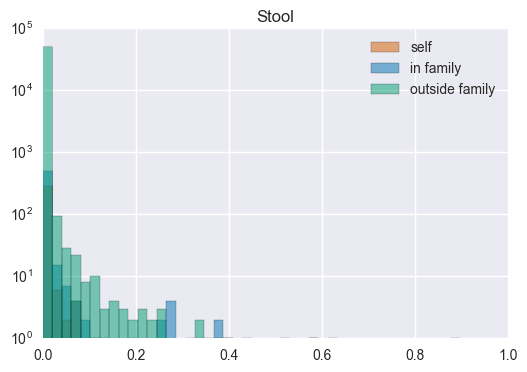

In [10]:
bins = np.linspace(0, 1, 50)
plt.hist(to_plot_stool["abundance"][to_plot_stool.in_fam == "self"], log=True, label="self", bins=bins, alpha=.5, color=colors[2])
plt.hist(to_plot_stool["abundance"][to_plot_stool.in_fam == "family"], log=True, label="in family", bins=bins, alpha=.5, color=colors[0])
plt.hist(to_plot_stool["abundance"][to_plot_stool.in_fam == "out"], log=True, label="outside family", bins=bins, alpha=.5, color=colors[1])
_ = plt.legend()
_ = plt.title("Stool")

In [11]:
to_plot_stool_grouped = to_plot_stool.groupby(to_plot_stool.in_fam).sum().reindex(['self', 'family', 'out'])
display(to_plot_stool_grouped)
test_stool = r_stats.mantelhaen_test(samples_stool)
print test_stool.rx2('p.value')

,abundance,pred_abundance
in_fam,,
self,0.8645,0.167392
family,7.5131,0.255155
out,20.6183,28.573353


[1] 0



In [12]:
samples_tongue = list()
to_plot_rows = list()

results_tongue = results[[i for i in results.columns if "tongue" in i.lower()]]
for fam in set(meta.family):
    fam02 = results_tongue.loc[meta.family==fam]
    fam02_inds = set(meta.loc[fam02.index, "anonymized_name"])
    for title1, row1 in fam02.iterrows():
        pred_count = row1.sum()/row1.shape[0]
        to_test_rows = list()
        for title2, value in row1.iteritems():
            if title2 == "Unknown":
                print "Unknown"
                continue
            elif meta.loc[title2, "anonymized_name"] == meta.loc[title1, "anonymized_name"]:
                in_fam = "self"
            elif meta.loc[title2, "anonymized_name"] in fam02_inds:
                in_fam = "family"
            else:
                in_fam = "out"
            to_plot_rows.append((in_fam, value, pred_count, title2))
            to_test_rows.append((in_fam, value*1000+1, pred_count*1000+1, title2))
        to_test = pd.DataFrame(to_test_rows, columns=columns)
        array = to_test.groupby(to_test.in_fam).sum().reindex(['self', 'family', 'out']).values
        samples_tongue.append(np.nan_to_num(array))

to_plot_tongue = pd.DataFrame(to_plot_rows, columns=columns)
samples_tongue = np.asarray(samples_stool).transpose([1,2,0])

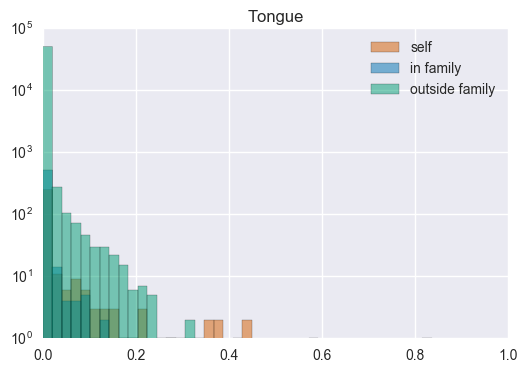

In [13]:
bins = np.linspace(0, 1, 50)
plt.hist(to_plot_tongue["abundance"][to_plot_tongue.in_fam == "self"], log=True, label="self", bins=bins, alpha=.5, color=colors[2])
plt.hist(to_plot_tongue["abundance"][to_plot_tongue.in_fam == "family"], log=True, label="in family", bins=bins, alpha=.5, color=colors[0])
plt.hist(to_plot_tongue["abundance"][to_plot_tongue.in_fam == "out"], log=True, label="outside family", bins=bins, alpha=.5, color=colors[1])
_ = plt.legend()
_ = plt.title("Tongue")

In [14]:
to_plot_tongue_grouped = to_plot_tongue.groupby(to_plot_tongue.in_fam).sum().reindex(['self', 'family', 'out'])
display(to_plot_tongue_grouped)
test_tongue = r_stats.mantelhaen_test(samples_tongue)
print test_tongue.rx2('p.value')

,abundance,pred_abundance
in_fam,,
self,8.2177,0.390279
family,2.8528,0.820638
out,55.6672,65.526783


[1] 1.715188e-168



In [15]:
samples_skin = list()
to_plot_rows = list()

results_skin = results[[i for i in results.columns if "forehead" in i.lower()]]
for fam in set(meta.family):
    fam02 = results_skin.loc[meta.family==fam]
    fam02_inds = set(meta.loc[fam02.index, "anonymized_name"])
    for title1, row1 in fam02.iterrows():
        pred_count = row1.sum()/row1.shape[0]
        to_test_rows = list()
        for title2, value in row1.iteritems():
            if title2 == "Unknown":
                print "Unknown"
                continue
            elif meta.loc[title2, "anonymized_name"] == meta.loc[title1, "anonymized_name"]:
                in_fam = "self"
            elif meta.loc[title2, "anonymized_name"] in fam02_inds:
                in_fam = "family"
            else:
                in_fam = "out"
            to_plot_rows.append((in_fam, value, pred_count, title2))
            to_test_rows.append((in_fam, value*1000+1, pred_count*1000+1, title2))
        to_test = pd.DataFrame(to_test_rows, columns=columns)
        array = to_test.groupby(to_test.in_fam).sum().reindex(['self', 'family', 'out']).values
        samples_skin.append(np.nan_to_num(array))

to_plot_skin = pd.DataFrame(to_plot_rows, columns=columns)
samples_skin = np.asarray(samples_skin).transpose([1,2,0])

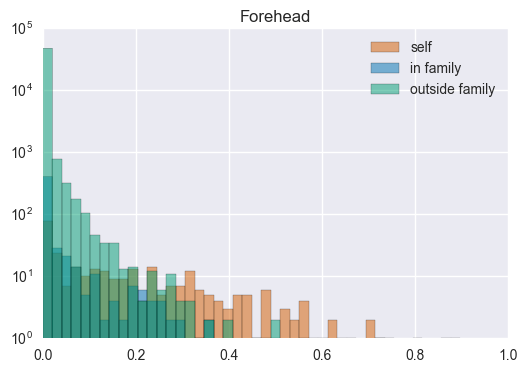

In [16]:
bins = np.linspace(0, 1, 50)
plt.hist(to_plot_skin["abundance"][to_plot_skin.in_fam == "self"], log=True, label="self", bins=bins, alpha=.5, color=colors[2])
plt.hist(to_plot_skin["abundance"][to_plot_skin.in_fam == "family"], log=True, label="in family", bins=bins, alpha=.5, color=colors[0])
plt.hist(to_plot_skin["abundance"][to_plot_skin.in_fam == "out"], log=True, label="outside family", bins=bins, alpha=.5, color=colors[1])
_ = plt.legend()
_ = plt.title("Forehead")

In [17]:
to_plot_skin_grouped = to_plot_skin.groupby(to_plot_skin.in_fam).sum().reindex(['self', 'family', 'out'])
display(to_plot_skin_grouped)
test_skin = r_stats.mantelhaen_test(samples_skin)
print test_skin.rx2('p.value')

,abundance,pred_abundance
in_fam,,
self,51.6314,1.156971
family,15.7609,2.008930
out,129.9629,194.189298


[1] 0



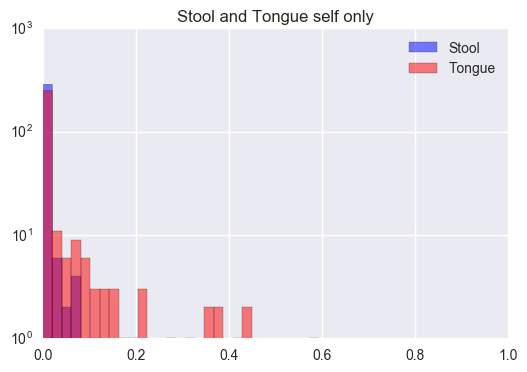

In [18]:
_ = plt.hist(to_plot_stool.loc[to_plot_stool.in_fam=="self"].abundance, log=True, alpha=.5, color="blue", bins=bins, label="Stool")
_ = plt.hist(to_plot_tongue.loc[to_plot_tongue.in_fam=="self"].abundance, log=True, alpha=.5, color="red", bins=bins, label="Tongue")
_ = plt.title("Stool and Tongue self only")
_ = plt.legend()

We have left out unknown so this is assuming that all unknown assignments are true.

## A Single Family Shows Cross Exposure of Bacteria

In this first section we explore the palms of all members of a single family to show the utility of our research.

In [19]:
sites = ['Forehead', 'Stool', 'Tongue']
people = ['Infant', 'Child', 'Mother', 'Father', 'Unrelated']

fam02 = results.loc[set(meta.index[meta.family==2]) & set(results.index)]
fam02_sources = np.array([".02." in i for i in fam02.columns])
fam02_vignette = fam02.loc[:, fam02_sources] # start with just this family
fam02_outfamily = fam02.loc[:, ~fam02_sources]
fam02_Forehead = [i for i in fam02_outfamily.columns if 'Forehead' in i]
fam02_vignette.loc[:, "out_Forehead"] = fam02_outfamily.loc[:, fam02_Forehead].sum(axis=1)
fam02_Stool = [i for i in fam02_outfamily.columns if 'Stool' in i]
fam02_vignette.loc[:, "out_Stool"] = fam02_outfamily.loc[:, fam02_Stool].sum(axis=1)
fam02_tongue = [i for i in fam02_outfamily.columns if 'Tongue' in i]
fam02_vignette.loc[:, "out_tongue"] = fam02_outfamily.loc[:, fam02_tongue].sum(axis=1)
fam02_vignette.loc[:, "Unknown"] = fam02["Unknown"]

# rename columns
new_columns_02 = [i.replace("797.02.HD.", "Father ") for i in fam02_vignette.columns]
new_columns_02 = [i.replace("797.02.HC.", "Child ") for i in new_columns_02]
new_columns_02 = [i.replace("797.02.HB.", "Mother ") for i in new_columns_02]
new_columns_02 = [i.replace("797.02.HA.", "Infant ") for i in new_columns_02]
new_columns_02[-1] = "Unknown"
new_columns_02[-2] = "Unrelated Tongue"
new_columns_02[-3] = "Unrelated Stool"
new_columns_02[-4] = "Unrelated Forehead"
# new_columns_02 = [i.replace("Forehead", "Skin") for i in new_columns_02]
fam02_vignette.columns = new_columns_02
fam02_vignette.columns = [(' ').join(list(reversed(i.split()))) for i in fam02_vignette.columns]

# rename index
new_names_02 = [i.split('.')[-2:] for i in fam02_vignette.index] 
new_names_02 = [' '.join(i) for i in new_names_02]
new_names_02 = [i.replace('HA', 'Infant') for i in new_names_02]
new_names_02 = [i.replace('HB', 'Mother') for i in new_names_02]
new_names_02 = [i.replace('HC', 'Child') for i in new_names_02]
new_names_02 = [i.replace('HD', 'Father') for i in new_names_02]
new_names_02 = [i.replace('LeftPalm', 'Left Palm') for i in new_names_02]
new_names_02 = [i.replace('RightPalm', 'Right Palm') for i in new_names_02]
fam02_vignette.index = new_names_02

# reorder columns and index
fam02_vignette = fam02_vignette[[' '.join(i) for i in itertools.product(sites, people)] + ["Unknown"]]
new_order = sorted([i for i in fam02_vignette.index if 'Father' in i]) + sorted([i for i in fam02_vignette.index if 'Mother' in i]) + \
            sorted([i for i in fam02_vignette.index if 'Child' in i]) + sorted([i for i in fam02_vignette.index if 'Infant' in i])
fam02_vignette = fam02_vignette.reindex(new_order)

/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/shafferm/miniconda2/envs/sourcetracker/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


['Father Left Palm', 'Father Right Palm', 'Mother Left Palm', 'Mother Right Palm', 'Child Left Palm', 'Infant Left Palm', 'Infant Right Palm']


In [20]:
display(fam02_vignette)

,Forehead Infant,Forehead Child,Forehead Mother,Forehead Father,Forehead Unrelated,Stool Infant,Stool Child,Stool Mother,Stool Father,Stool Unrelated,Tongue Infant,Tongue Child,Tongue Mother,Tongue Father,Tongue Unrelated,Unknown
Father Left Palm,0.0001,0.0000,0.0003,0.1570,0.0157,0.0001,0.0000,0.0000,0.0002,0.8261,0.0000,0.0,0.0000,0.0000,0.0005,0.0000
Father Right Palm,0.0001,0.0000,0.0017,0.2913,0.6252,0.0002,0.0656,0.0000,0.0000,0.0118,0.0000,0.0,0.0001,0.0000,0.0040,0.0000
Mother Left Palm,0.0000,0.0002,0.1484,0.0000,0.4027,0.2653,0.0000,0.0000,0.0000,0.0085,0.0000,0.0,0.0000,0.0002,0.1328,0.0419
Mother Right Palm,0.0000,0.0000,0.0198,0.0001,0.5530,0.0006,0.0000,0.0000,0.0000,0.0099,0.0000,0.0,0.0000,0.0000,0.3698,0.0468
Child Left Palm,0.0097,0.1421,0.0000,0.0000,0.2477,0.0000,0.0000,0.2838,0.0000,0.0645,0.0038,0.0,0.0000,0.0000,0.2247,0.0237
Infant Left Palm,0.0003,0.0000,0.0000,0.0000,0.1442,0.0000,0.0000,0.0000,0.0000,0.0001,0.0228,0.0,0.0000,0.0000,0.8326,0.0000
Infant Right Palm,0.0001,0.0023,0.0000,0.0002,0.4468,0.0000,0.0000,0.0000,0.0000,0.0047,0.0123,0.0,0.0000,0.0000,0.5233,0.0103


In [21]:
# setup figure making
# precolors = ['1', str(2/3.), str(1/3.)]
preprecolors = sns.color_palette('colorblind', 4)
precolors = preprecolors[:3]
vignette_colors = [j for i in precolors for j in [i]*5] + [preprecolors[-1]]
prehatches = ('\\', '..', 'x', 'O', '')
hatches = (list(prehatches*3)+[''])
hatches = [j for k in [[i]*7 for i in hatches] for j in k]
xticks = [i/10. for i in range(10)]

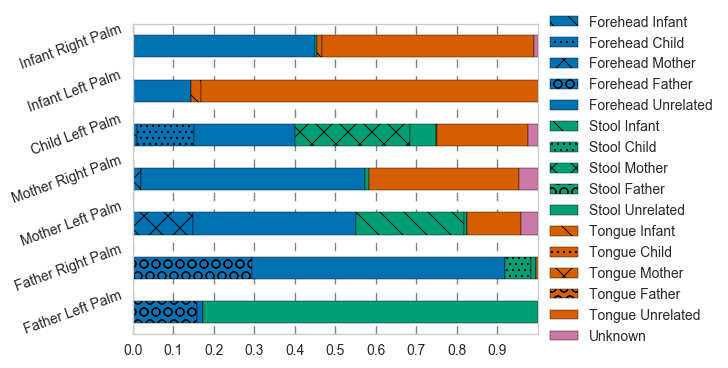

In [22]:
# make figure
with sns.axes_style("whitegrid"):
    f = plt.figure(frameon=True, facecolor='white')
    plot = fam02_vignette.plot(kind="barh", stacked=True, xlim=(0,1), color=vignette_colors, rot=20, ax=f.gca(), xticks=xticks, edgecolor="black")
    for bar, hatch in zip(plot.patches, hatches):
        bar.set_hatch(hatch)
    plot.set_axisbelow(True)
    plot.xaxis.grid(color='gray', linestyle='dashed')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    f.subplots_adjust(right=0.8)
#     f.gca().facecolor('white')
#     plt.savefig('figures/fig2.svg', bbox_inches='tight')
    plt.savefig('figures/fig2.png', bbox_inches='tight', dpi=500)
# !qlmanage -t -s 10000 -o figures/ figures/fig2.svg

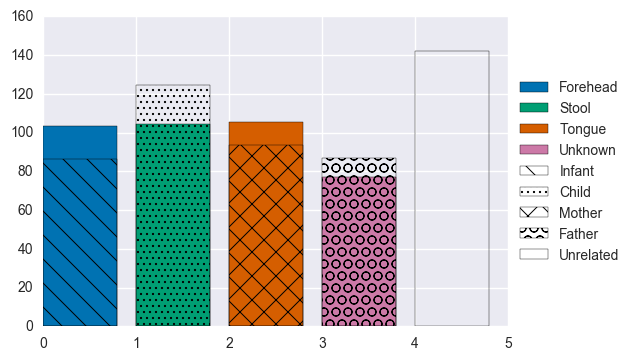

In [23]:
# make fake figure to pull legends
colors = preprecolors
index1 = np.arange(len(colors))
arrays1 = [np.random.normal(100,50,10) for i in xrange(len(colors))]
sites_Unknown = sites + ["Unknown"]
rects1 = plt.bar(index1, np.mean(arrays1, axis=1))
for i, rect in enumerate(rects1):
    rect.set_color(colors[i])
    rect.set_edgecolor("black")
    rect.set_label(sites_Unknown[i])
index2 = np.arange(len(prehatches))
arrays2 = [np.random.normal(100,50,10) for i in xrange(len(prehatches))]
rects2 = plt.bar(index2, np.mean(arrays2, axis=1), fill=False)
for i, rect in enumerate(rects2):
    rect.set_hatch(prehatches[i])
    rect.set_label(people[i])

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.savefig('figures/fig2_legend.png', bbox_inches='tight', dpi=500)
# plt.savefig('figures/fig2_legend.svg', bbox_inches='tight')
# !qlmanage -t -s 10000 -o figures/ figures/fig2_legend.svg

So now we have generated a good plot and a good legend showing our results from looking at a single family.

Now we want to see if things map to sites from our family significantly more often than to other sites. We'll make a plot and look at our statistics.

MannwhitneyuResult(statistic=8814.5, pvalue=1.1836094469766499e-06)


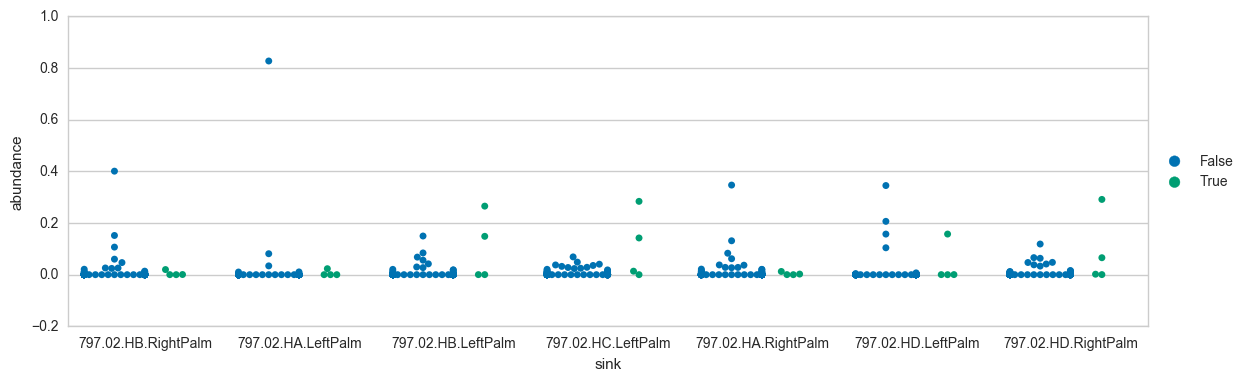

In [24]:
fam02_inds = set(meta[meta.family==2].anonymized_name)
columns = ["in_fam02", "abundance", "sink"]
palm_ind_source = results.groupby([meta.loc[i, "anonymized_name"] if i!="Unknown" else "Unknown" for i in results.columns], axis=1).sum()
fam02_palm_ind_source = palm_ind_source.loc[fam02.index].transpose()
to_plot = pd.DataFrame(columns=columns)
for title1, row1 in fam02_palm_ind_source.iterrows():
    in_fam02 = (title1 in fam02_inds)
    for title2, value in row1.iteritems():
        to_plot = to_plot.append(pd.Series([in_fam02, value, title2], index=columns), ignore_index=True)
to_plot["neg_log_abundance"] = -1*np.log(to_plot.abundance)
to_plot = to_plot.replace(np.inf, 0)
print mannwhitneyu(to_plot[to_plot.in_fam02].abundance, to_plot[to_plot.in_fam02==False].abundance)
with sns.axes_style("whitegrid"):
    f = plt.figure(figsize=[16,4])
    sns.swarmplot(data=to_plot, x="sink", y="abundance", hue="in_fam02", split=True, palette='colorblind')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(right=0.8)

So here we see that a read from a sample in family 2 is more likely to map to a sample from another member of family 2 than any other sample (p<10e-5).

Let's see if infant tongue bacteria is significantly more likely to occur on infant palm than an other individual sample. We will do a one sample Wilcoxon signed rant test for each palm.

In [25]:
infant_tongue = "797.02.HA.Tongue"
infant_palms = ["797.02.HA.RightPalm", "797.02.HA.LeftPalm"]
tongue_samples = set([i for i in fam02.columns if 'tongue' in i.lower()])
for palm in infant_palms:
    tongue_percent = fam02.loc[palm, infant_tongue]
    other_percents = fam02.loc[palm, tongue_samples - set(infant_tongue)]
    print palm, wilcoxon(other_percents-tongue_percent)
del tongue_samples

797.02.HA.RightPalm WilcoxonResult(statistic=842.0, pvalue=1.0198681211988334e-26)
797.02.HA.LeftPalm WilcoxonResult(statistic=170.0, pvalue=5.5847948642283021e-35)


Both have p < 10e-25 so the tongue bacteria on the infant's palms is much more likely to have come from itself than other infants.

Now let's test if stool bacteria is more likely to have come from the family. We'll do one test of family stool sources vs. nonfamily stool sources with Mann-Whitney U.

In [26]:
in_fam02_stool_samples = [i for i in fam02.columns if 'stool' in i.lower() and meta.loc[i, 'family']==2]
fam02_stool = fam02[[i for i in fam02.columns if 'stool' in i.lower()]]
mannwhitneyu(fam02_stool[in_fam02_stool_samples].values.flatten(),
             fam02_stool[list(set(fam02_stool.columns)-set(in_fam02_stool_samples))].values.flatten())

MannwhitneyuResult(statistic=13744.0, pvalue=0.0098755938111981332)

So stool is significantly more likely to come from family sources than outside of the family soruces (p<.01).

Next we want to test if significantly more of baby's fecal bacteria maps to mom's left hand than other fecal samples. We will also test if there is significantly more bacteria from mom's feces on child's left hand.

In [27]:
fam02_stool_person = fam02_stool.divide(fam02_stool.sum(axis=1), axis=0)
# baby stool bacteria on mom's left palm
print wilcoxon(fam02_stool_person.loc["797.02.HB.LeftPalm", set(fam02_stool_person.columns)-set(("797.02.HB.LeftPalm"))]-fam02_stool_person.loc["797.02.HB.LeftPalm", "797.02.HA.Stool"])
# mom stool bacteria on child's left palm
print wilcoxon(fam02_stool_person.loc["797.02.HC.LeftPalm", set(fam02_stool_person.columns)-set(("797.02.HC.LeftPalm"))]-fam02_stool_person.loc["797.02.HC.LeftPalm", "797.02.HB.Stool"])

WilcoxonResult(statistic=0.0, pvalue=2.3931089459269077e-34)
WilcoxonResult(statistic=0.0, pvalue=4.3334076545712277e-33)


So both are very significant (p<10e-32).

## Testing for significant stool or tongue contamination

In [28]:
results_site = results.groupby([i.split('.')[-1] for i in results.columns], axis=1).sum()
results_site_var = results_var.groupby([i.split('.')[-1] for i in results_var.columns], axis=1).sum()
results_site_std = np.sqrt(results_site_var)
sig_stool = results_site.index[(results_site.Stool - 2*results_site_std.Stool) > 0]
sig_tongue = results_site.index[(results_site.Tongue - 2*results_site_std.Tongue) > 0]
print "Number and percent of palms with significant amount:"
print "Stool", len(sig_stool), len(sig_stool)/len(results_site.Stool)
print "Tongue", len(sig_tongue), len(sig_tongue)/len(results_site.Tongue)
sig_ind_stool = list()
sig_ind_tongue = list()
individuals = set(meta.anonymized_name)
for individual in individuals:
    palms = meta.index[meta.anonymized_name == individual]
    if len(set(palms) & set(sig_stool)) > 0:
        sig_ind_stool.append(individual)
    if len(set(palms) & set(sig_tongue)) > 0:
        sig_ind_tongue.append(individual)
print "Number and percent of indviduals with at least one palm with a significant amount:"
print "Stool", len(sig_ind_stool), len(sig_ind_stool)/len(individuals)
print "Tongue", len(sig_ind_tongue), len(sig_ind_tongue)/len(individuals)

Number and percent of palms with significant amount:
Stool 149 0.488524590164
Tongue 205 0.672131147541
Number and percent of indviduals with at least one palm with a significant amount:
Stool 104 0.604651162791
Tongue 136 0.790697674419


## Broader Analysis of Full Cohort

So now we are going to look at the full set of 166 individuals from 60 families. We will start with some summary figures.

Forehead 0.672 0.647066229508 0.0 0.9903 287 0.940983606557
Stool 0.0173 0.0950685245902 0.0 0.989 36 0.118032786885
Tongue 0.1308 0.218812131148 0.0 0.9751 100 0.327868852459
Unknown 0.0231 0.0390531147541 0.0 0.4143 4 0.0131147540984


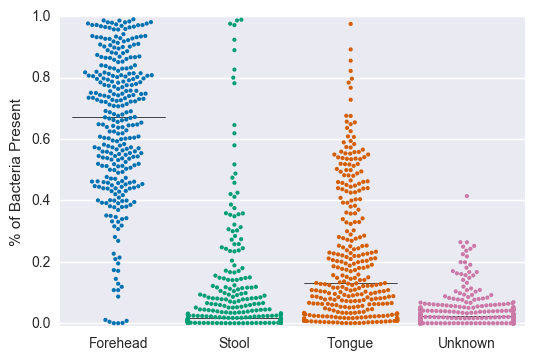

In [29]:
results_site = results.groupby([i.split('.')[-1] for i in results.columns], axis=1).sum()
# results_site.columns = [i if i.lower() != 'forehead' else 'Skin' for i in results_site.columns]
# ax = sns.swarmplot(data=results_site, color=sns.xkcd_rgb["charcoal grey"], size=3)
ax = sns.swarmplot(data=results_site, palette=sns.color_palette("colorblind"), size=3)
ax.set_ylim((-0.01, 1.0001))
ax.set_ylabel("% of Bacteria Present")
for i, column in enumerate(results_site):
    med = results_site[column].median()
    mean = results_site[column].mean()
    min_ = results_site[column].min()
    max_ = results_site[column].max()
    over_25 = np.sum(results_site[column] > .25)
    ax.plot([i-.4, i+.4], [med, med], color="black", linewidth=.5)
    print column, med, mean, min_, max_, over_25, over_25/results.shape[0]
plt.savefig('figures/fig3A.png', dpi=500, bbox_inches="tight")

So we have a swarm plot giving us an overview of our data. It is very obvious that the palm is primarily made up of palm bacteria but is median 13.1% tongue bacteria.

Let's now do the same thing with specificity. Specificity here means the percent of a palm sample that is from either another site on the body of the same individual (called self), from the body sites of family members (family) and from other individuals in the study outside the family (called Unrelated). This final group is called Unrelated because these microbes are often Unrelated across individuals in the study and so could not be classified to the self or a family member.

In [30]:
specificities = ['Self', 'Family', 'Unrelated', 'Unknown']

# Basic palm specificity
results_specificity = pd.DataFrame(index=specificities)

for palm, data in results.iterrows():
    specificities_row = get_specificity(data, meta)
    results_specificity[palm] = data.groupby(specificities_row).sum()

results_specificity = results_specificity.transpose()

Self 0.1331 0.199060983607
Family 0.0276 0.0920333333333
Unrelated 0.7037 0.675887540984
Unknown 0.0231 0.0390531147541


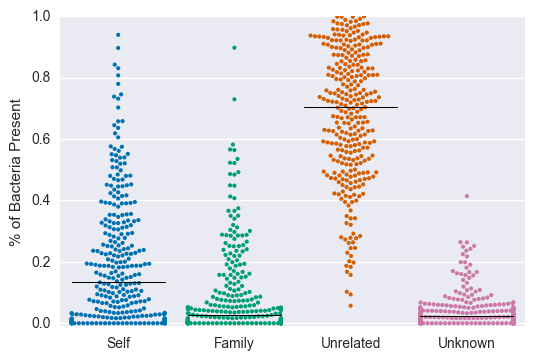

In [31]:
# ax = sns.swarmplot(data=results_specificity, color=sns.xkcd_rgb["charcoal grey"], size=3)
ax = sns.swarmplot(data=results_specificity, palette=sns.color_palette("colorblind"), size=3, zorder=1)
ax.set_ylim((-0.01, 1.0001))
ax.set_ylabel("% of Bacteria Present")
for i, column in enumerate(results_specificity):
    med = results_specificity[column].median()
    avg = results_specificity[column].mean()
    print column, med, avg
    body = plt.Line2D([i-.4, i+.4], [med, med], color="black", linewidth=.75)
    ax.add_line(body)
plt.savefig('figures/fig3B.png', dpi=500, bbox_inches="tight")

So here we see the varitey of specificity levels across our cohort. Most bacteria are Unrelated across our population while some being self specific (median 13.3%).

We can also combine these site origin and specificity summaries. This will give us how much of each body site is at which specificity.

In [32]:
site_specificies = [' '.join(i) for i in itertools.product(sites, specificities[:-1])] + ['Unknown Unknown']

results_site_specificity = pd.DataFrame(index=site_specificies)

for palm, data in results.iterrows():
    curr_row = np.zeros(len(site_specificies))
    curr_specificities = get_specificity(data, meta)
    for i, (source, value) in enumerate(data.iteritems()):
#         site = source.split('.')[-1].replace("Forehead", "Skin")
        site = source.split('.')[-1]
        specificity = curr_specificities[i]
        curr_row[site_specificies.index(' '.join((site, specificity)))] += value
    results_site_specificity[palm] = curr_row

new_index = list(results_site_specificity.index)
new_index[-1] = "Unknown"
results_site_specificity.index = new_index
results_site_specificity = results_site_specificity.transpose()

Forehead Self 0.1107
Forehead Family 0.0053
Forehead Unrelated 0.418
Stool Self 0.0
Stool Family 0.0
Stool Unrelated 0.0119
Tongue Self 0.0
Tongue Family 0.0
Tongue Unrelated 0.1055
Unknown 0.0231


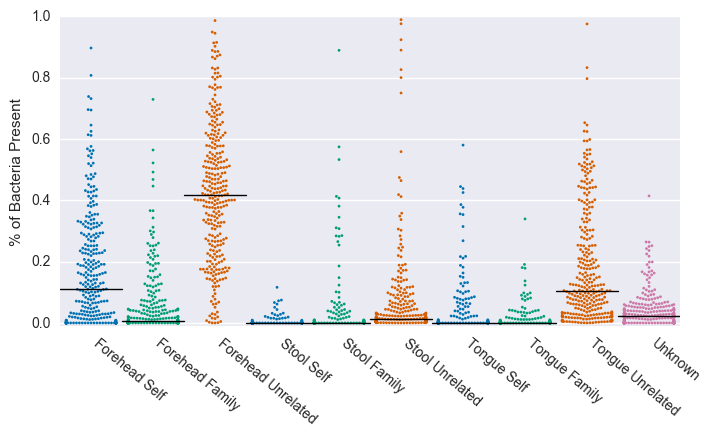

In [33]:
f = plt.figure(figsize=[8., 4.])
# ax = sns.swarmplot(data=results_site_specificity, color=sns.xkcd_rgb["charcoal grey"], size=2)
# ax = sns.swarmplot(data=results_site_specificity, palette=sns.color_palette("colorblind"), size=2)
fig3_precolors = sns.color_palette('colorblind', 4)
fig3_colors = fig3_precolors[:3]*3 + [fig3_precolors[-1]]
ax = sns.swarmplot(data=results_site_specificity, palette=fig3_colors, size=2, zorder=1)
plt.xticks(rotation=365-45, ha='left')
ax.set_ylim((-0.01, 1.001))
ax.set_ylabel("% of Bacteria Present")
for i, column in enumerate(results_site_specificity):
    med = results_site_specificity[column].median()
    print column, med
    ax.plot([i-.5, i+.5], [med, med], color="black", linewidth=1)

Here we can see how specificity and origin site changes across samples. Unrelated skin bacteria make up the most of palm bacteria as well as self specific skin bacteria and Unrelated tongue bacteria.

To see the relative make up of each site in regards to specificity we'll make another plot.

In [34]:
results_site_specificity_rel = results_site_specificity.copy()
for sample, data in results_site_specificity_rel.iterrows():
    skin_set = data[0:3]/np.sum(data[0:3])
    stool_set = data[3:6]/np.sum(data[3:6])
    tongue_set = data[6:9]/np.sum(data[6:9])
    results_site_specificity_rel.loc[sample] = list(skin_set) + list(stool_set) + list(tongue_set) + [data[-1]]
results_site_specificity_rel_square = pd.DataFrame(np.zeros((3,3)), index=sites, columns=specificities[:-1])
for name, value in results_site_specificity_rel.mean().iteritems():
    try:
        site, specificity = name.split()
        results_site_specificity_rel_square.loc[site, specificity] = value
    except ValueError:
        pass
display(results_site_specificity_rel_square)
results_site_specificity_rel_se_square = pd.DataFrame(np.zeros((3,3)), index=sites, columns=specificities[:-1])
for name, value in results_site_specificity_rel.sem().iteritems():
    try:
        site, specificity = name.split()
        results_site_specificity_rel_se_square.loc[site, specificity] = value
    except ValueError:
        pass
display(results_site_specificity_rel_se_square)

,Self,Family,Unrelated
Forehead,0.256129,0.077956,0.665915
Stool,0.041977,0.142030,0.815993
Tongue,0.076836,0.050638,0.872526


,Self,Family,Unrelated
Forehead,0.014872,0.008249,0.014930
Stool,0.008057,0.015144,0.016366
Tongue,0.009661,0.008160,0.012232


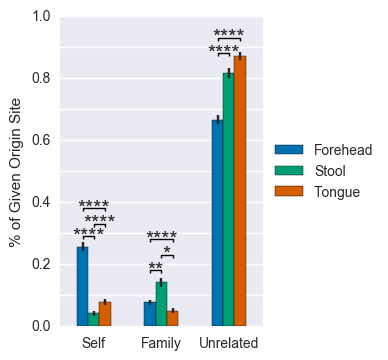

In [35]:
f = plt.figure(figsize=[3, 4])
# results_site_specificity_rel_square.transpose().plot(kind="bar", colormap="Greys", rot=0, ax=f.gca(), edgecolor='black',
#                                                      yerr=results_site_specificity_rel_se_square.transpose())
results_site_specificity_rel_square.transpose().plot(kind="bar", color=sns.color_palette('colorblind'), rot=0, ax=f.gca(), edgecolor='black',
                                                     yerr=results_site_specificity_rel_se_square.transpose())
plt.grid(False)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.grid(True, which="both")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(right=0.8)
_ = plt.ylabel("% of Given Origin Site")
plt.ylim((0, 1))

# Self sig bars
self_center = 0
significance_bar(self_center-vert_offset, self_center, .29, '****')
significance_bar(self_center, self_center+vert_offset, .33, "****")
significance_bar(self_center-vert_offset, self_center+vert_offset, .38 , "****")
# Family sig bars
family_center = 1
significance_bar(family_center-vert_offset, family_center, .18, '**')
significance_bar(family_center, family_center+vert_offset, .23, "*")
significance_bar(family_center-vert_offset, family_center+vert_offset, .28, "****")
# # Unspecific sig bars
unrelated_center = 2
significance_bar(unrelated_center-vert_offset, unrelated_center, .88, '****')
significance_bar(unrelated_center-vert_offset, unrelated_center+vert_offset, .93, "****")

plt.savefig('figures/fig3C.png', dpi=500, bbox_inches="tight")

In [36]:
print "Self"
print "Skin vs. stool", mannwhitneyu(results_site_specificity_rel["Forehead Self"],
                                     results_site_specificity_rel["Stool Self"]).pvalue
print "Stool vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Self"],
                                     results_site_specificity_rel["Stool Self"]).pvalue
print "Skin vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Self"],
                                     results_site_specificity_rel["Forehead Self"]).pvalue
print "Family"
print "Skin vs. stool", mannwhitneyu(results_site_specificity_rel["Forehead Family"],
                                     results_site_specificity_rel["Stool Family"]).pvalue
print "Stool vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Family"],
                                     results_site_specificity_rel["Stool Family"]).pvalue
print "Skin vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Family"],
                                     results_site_specificity_rel["Forehead Family"]).pvalue
print "Unrelated"
print "Skin vs. stool", mannwhitneyu(results_site_specificity_rel["Forehead Unrelated"],
                                     results_site_specificity_rel["Stool Unrelated"]).pvalue
print "Stool vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Unrelated"],
                                     results_site_specificity_rel["Stool Unrelated"]).pvalue
print "Skin vs. tongue", mannwhitneyu(results_site_specificity_rel["Tongue Unrelated"],
                                     results_site_specificity_rel["Forehead Unrelated"]).pvalue

Self
Skin vs. stool 7.53437879914e-51
Stool vs. tongue 1.502470601e-05
Skin vs. tongue 1.33050714685e-32
Family
Skin vs. stool 0.00191720696592
Stool vs. tongue 0.0312839059904
Skin vs. tongue 3.98309065312e-10
Unrelated
Skin vs. stool 4.35516353913e-21
Stool vs. tongue 0.394390352942
Skin vs. tongue 8.59508623629e-31


With this we can clearly see that palm bacteria originiating from the skin are often self specific and stool bacteria seem to be disproportionately family specific.

### Do dogs affect palm bacterial body site source?

So now we want to see if dog ownership affects the body site source composition of bacteria on palms.

In [37]:
has_dog = list()
for i in results_site.index:
    fam_i = meta.loc[i, 'family']
    has_dog.append('Has Dog' if 'Pet' in full_meta.loc[full_meta.family==fam_i].role.values else 'No Dog')
results_site_dog = results_site.groupby(has_dog)
display(results_site_dog.mean())

,Forehead,Stool,Tongue,Unknown
Has Dog,0.654611,0.084942,0.196485,0.063962
No Dog,0.643386,0.100008,0.229703,0.026902


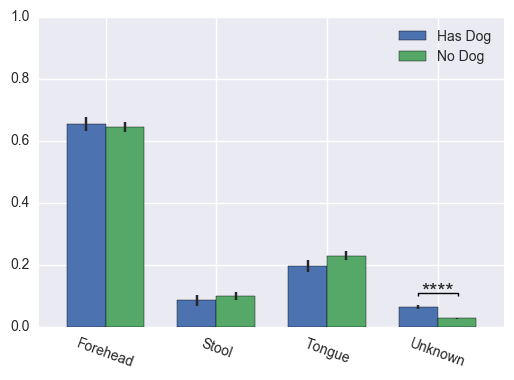

In [38]:
_ = results_site_dog.mean().transpose().plot(kind="bar", ylim=(0,1), rot=360-20, width=.7, edgecolor='black',
                                             yerr=results_site_dog.sem().transpose())

significance_bar(3-.18, 3+.18, .11, "****")
plt.savefig("figures/supp_fig1A.png", dpi=500, bbox_inches='tight')

Only significant result is in the unknown category. This could be bacteria that are of dog origin being more present in dog owners.

In [39]:
print "Skin", mannwhitneyu(results_site_dog.get_group("No Dog")["Forehead"],
                           results_site_dog.get_group("Has Dog")["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_site_dog.get_group("No Dog")["Stool"],
                           results_site_dog.get_group("Has Dog")["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_site_dog.get_group("No Dog")["Tongue"],
                           results_site_dog.get_group("Has Dog")["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_site_dog.get_group("No Dog")["Unknown"],
                           results_site_dog.get_group("Has Dog")["Unknown"]).pvalue

Skin 0.42946824918
Stool 0.366316012948
Tongue 0.100505860699
Unknown 7.16795536394e-08


### Is there a difference between Left and Right Palms?

We are curious to see if there is a difference between left and right palms in terms of bacterial body site origin.

In [40]:
rl_hand = list()
for i in results_site.index:
    palm = i.split('.')[-1]
    rl_hand.append("%s %s" % (palm[:-4], palm[-4:]))
results_site_hand = results_site.groupby(rl_hand)
display(results_site_hand.mean())

,Forehead,Stool,Tongue,Unknown
Left Palm,0.621595,0.135131,0.205282,0.037993
Right Palm,0.670765,0.057795,0.231401,0.040040


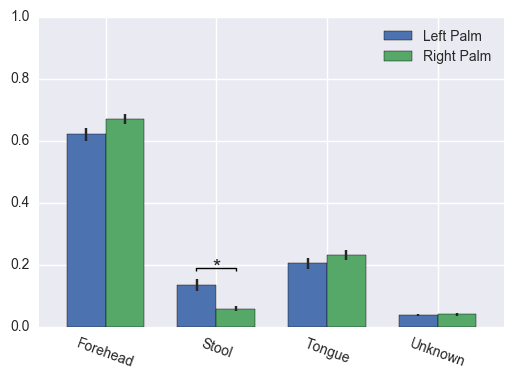

In [41]:
_ = results_site_hand.mean().transpose().plot(kind="bar", ylim=(0,1), rot=360-20, width=.7, edgecolor='black',
                                              yerr=results_site_hand.sem().transpose())

significance_bar(1-.18, 1+.18, .19, "*")
plt.savefig("figures/supp_fig1B.png", dpi=500, bbox_inches='tight')

The only result present is the stool. It is curious that the left palm has more stool bacteria than the right palm. Most individuals wipe with their dominant hand and most individuals are right handed. Maybe the right palm is just more exposed as more activity is done with the dominant hand.

In [42]:
print "Skin", mannwhitneyu(results_site_hand.get_group("Left Palm")["Forehead"],
                           results_site_hand.get_group("Right Palm")["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_site_hand.get_group("Left Palm")["Stool"],
                            results_site_hand.get_group("Right Palm")["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_site_hand.get_group("Left Palm")["Tongue"],
                             results_site_hand.get_group("Right Palm")["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_site_hand.get_group("Left Palm")["Unknown"],
                              results_site_hand.get_group("Right Palm")["Unknown"]).pvalue

Skin 0.0901745325436
Stool 0.0155530983211
Tongue 0.066451007109
Unknown 0.402631783448


## The Origin Site and Specificity of Origin of Hand Bacteria Decreases with Age

So now we have established a general profile of palm bacteria we can look to see how these profiles change. First we look to see if all these breakdowns of the data changed with age. To do this we broke up our subjects into three age categories: infants (0-2 years), children (3-18 years) and adults (19+ years). Let's start with a plot of how site origin of bacteria on palms changes with age.

In [43]:
subject_ages = np.array([meta.loc[i, 'age_group'].title() for i in results_site.index])
results_age_site = results_site.groupby(subject_ages).mean()
results_age_site = results_age_site.reindex(['Infant', 'Child', 'Adult'])
display(results_age_site)
results_age_site_se = results_site.groupby(subject_ages).sem()
results_age_site_se = results_age_site_se.reindex(['Infant', 'Child', 'Adult'])

,Forehead,Stool,Tongue,Unknown
Infant,0.506277,0.018126,0.464451,0.011146
Child,0.594013,0.070368,0.288397,0.047221
Adult,0.676996,0.110722,0.170357,0.041925


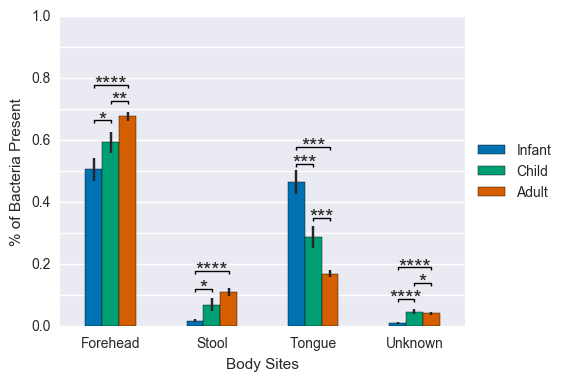

In [44]:
# results_age_site.transpose().plot(kind="bar", ylim=(0,1), color=precolors+["gray"], yerr=results_age_site_se.transpose(), rot=0, width=.5, edgecolor="black")
results_age_site.transpose().plot(kind="bar", ylim=(0,1), color=sns.color_palette('colorblind'), yerr=results_age_site_se.transpose(), rot=0, width=.5, edgecolor="black")
plt.ylabel("% of Bacteria Present")
plt.xlabel("Body Sites")
plt.grid(False)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.grid(True, which="both")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(right=0.8)
# Forehead sig bars
Forehead_center = 0
significance_bar(Forehead_center-vert_offset, Forehead_center, results_age_site.loc['Child', 'Forehead']+.07, '*')
significance_bar(Forehead_center, Forehead_center+vert_offset, results_age_site.loc['Adult', 'Forehead']+.05, "**")
significance_bar(Forehead_center-vert_offset, Forehead_center+vert_offset, .78, "****")
# Stool sig bars
Stool_center = 1
significance_bar(Stool_center-vert_offset, Stool_center, results_age_site.loc['Child', 'Stool']+.05, '*')
significance_bar(Stool_center-vert_offset, Stool_center+vert_offset, .18, "****")
# tongue sig bars
tongue_center = 2
significance_bar(tongue_center-vert_offset, tongue_center, results_age_site.loc['Infant', 'Tongue']+.06, '***')
significance_bar(tongue_center, tongue_center+vert_offset, results_age_site.loc['Child', 'Tongue']+.06, "***")
significance_bar(tongue_center-vert_offset, tongue_center+vert_offset, .58, "***")
# Unknown sig bars
Unknown_center = 3
significance_bar(Unknown_center-vert_offset, Unknown_center, results_age_site.loc['Child', 'Unknown']+.04, '****')
significance_bar(Unknown_center, Unknown_center+vert_offset, .14, "*")
significance_bar(Unknown_center-vert_offset, Unknown_center+vert_offset, .19, "****")
plt.savefig('figures/fig4A.png', dpi=500)

Key: \*: p<.05 \*\*: p<.01 \*\*\*: p<.001 \*\*\*\*: p<.0001

We jumped ahead here and already added significance bars. We'll calculate the significance now.

In [45]:
infantchild_skin_same = mannwhitneyu(results_site[subject_ages=='Infant'].Forehead,
                                     results_site[subject_ages=='Child'].Forehead)
infantadult_skin_same = mannwhitneyu(results_site[subject_ages=='Infant'].Forehead,
                                     results_site[subject_ages=='Adult'].Forehead)
childadult_skin_same = mannwhitneyu(results_site[subject_ages=='Child'].Forehead,
                                    results_site[subject_ages=='Adult'].Forehead)
print "p-value for difference of means of Forehead originating bacteria between infants and children: %.2e" % infantchild_skin_same.pvalue
print "p-value for difference of means of Forehead originating bacteria between infants and adults: %.2e" % infantadult_skin_same.pvalue
print "p-value for difference of means of Forehead originating bacteria between children and adults: %.2e" % childadult_skin_same.pvalue
print

infantchild_Stool_same = mannwhitneyu(results_site[subject_ages=='Infant'].Stool,
                                      results_site[subject_ages=='Child'].Stool)
infantadult_Stool_same = mannwhitneyu(results_site[subject_ages=='Infant'].Stool,
                                      results_site[subject_ages=='Adult'].Stool)
childadult_Stool_same = mannwhitneyu(results_site[subject_ages=='Child'].Stool,
                                     results_site[subject_ages=='Adult'].Stool)
print "p-value for difference of means of Stool originating bacteria between infants and children: %.2e" % infantchild_Stool_same.pvalue
print "p-value for difference of means of Stool originating bacteria between infants and adults: %.2e" % infantadult_Stool_same.pvalue
print "p-value for difference of means of Stool originating bacteria between children and adults: %.2e" % childadult_Stool_same.pvalue
print

infantchild_tongue_same = mannwhitneyu(results_site[subject_ages=='Infant'].Tongue,
                                       results_site[subject_ages=='Child'].Tongue)
infantadult_tongue_same = mannwhitneyu(results_site[subject_ages=='Infant'].Tongue,
                                       results_site[subject_ages=='Adult'].Tongue)
childadult_tongue_same = mannwhitneyu(results_site[subject_ages=='Child'].Tongue,
                                      results_site[subject_ages=='Adult'].Tongue)
print "p-value for difference of means of tongue originating bacteria between infants and children: %.2e" % infantchild_tongue_same.pvalue
print "p-value for difference of means of tongue originating bacteria between infants and adults: %.2e" % infantadult_tongue_same.pvalue
print "p-value for difference of means of tongue originating bacteria between children and adults: %.2e" % childadult_tongue_same.pvalue
print

infantchild_Unknown_same = mannwhitneyu(results_site[subject_ages=='Infant'].Unknown,
                                        results_site[subject_ages=='Child'].Unknown)
infantadult_Unknown_same = mannwhitneyu(results_site[subject_ages=='Infant'].Unknown,
                                        results_site[subject_ages=='Adult'].Unknown)
childadult_Unknown_same = mannwhitneyu(results_site[subject_ages=='Child'].Unknown,
                                       results_site[subject_ages=='Adult'].Unknown)
print "p-value for difference of means of Unknown originating bacteria between infants and children: %.2e" % infantchild_Unknown_same.pvalue
print "p-value for difference of means of Unknown originating bacteria between infants and adults: %.2e" % infantadult_Unknown_same.pvalue
print "p-value for difference of means of Unknown originating bacteria between children and adults: %.2e" % childadult_Unknown_same.pvalue

p-value for difference of means of Forehead originating bacteria between infants and children: 3.55e-02
p-value for difference of means of Forehead originating bacteria between infants and adults: 1.47e-05
p-value for difference of means of Forehead originating bacteria between children and adults: 6.53e-03

p-value for difference of means of Stool originating bacteria between infants and children: 1.04e-02
p-value for difference of means of Stool originating bacteria between infants and adults: 2.15e-05
p-value for difference of means of Stool originating bacteria between children and adults: 1.70e-01

p-value for difference of means of tongue originating bacteria between infants and children: 1.01e-03
p-value for difference of means of tongue originating bacteria between infants and adults: 1.39e-10
p-value for difference of means of tongue originating bacteria between children and adults: 1.81e-04

p-value for difference of means of Unknown originating bacteria between infants and c

So here are our p-values for these significance tests.

Now let's do the same thing for specificites that we have done here with sites.

In [46]:
results_age_specificity = results_specificity.groupby(subject_ages).mean()
results_age_specificity = results_age_specificity.reindex(['Infant', 'Child', 'Adult'])
# results_age_specificity = results_age_specificity[results_age_specificity.columns[:-1]]
display(results_age_specificity)
results_age_specificity_se = results_specificity.groupby(subject_ages).sem()
results_age_specificity_se = results_age_specificity_se.reindex(['Infant', 'Child', 'Adult'])
# results_age_specificity_se = results_age_specificity_se[results_age_specificity_se.columns[:-1]]

,Self,Family,Unrelated,Unknown
Infant,0.390306,0.022669,0.575880,0.011146
Child,0.238300,0.094900,0.619579,0.047221
Adult,0.163782,0.102971,0.700198,0.041925


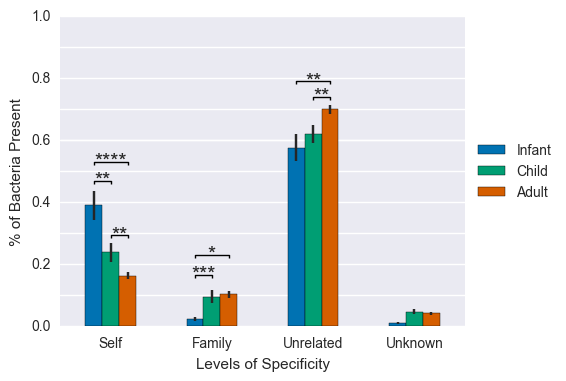

In [47]:
# results_age_specificity.transpose().plot(kind="bar", ylim=(0,1), color=precolors+["0"], yerr=results_age_specificity_se.transpose(), rot=0, width=.5, edgecolor='black')
results_age_specificity.transpose().plot(kind="bar", ylim=(0,1), color=sns.color_palette('colorblind'), yerr=results_age_specificity_se.transpose(), rot=0, width=.5, edgecolor='black')

plt.ylabel("% of Bacteria Present")
plt.xlabel("Levels of Specificity")
plt.grid(False)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.grid(True, which="both")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(right=0.8)
# Self sig bars
Forehead_center = 0
significance_bar(Forehead_center-vert_offset, Forehead_center, results_age_specificity.loc["Infant", "Self"]+.08, '**')
significance_bar(Forehead_center, Forehead_center+vert_offset, results_age_specificity.loc['Child', 'Self']+.055, "**")
significance_bar(Forehead_center-vert_offset, Forehead_center+vert_offset, .53 , "****")
# Family sig bars
Stool_center = 1
significance_bar(Stool_center-vert_offset, Stool_center, results_age_specificity.loc['Child', 'Family']+.07, '***')
significance_bar(Stool_center-vert_offset, Stool_center+vert_offset, .23, "*")
# Unspecific sig bars
tongue_center = 2
significance_bar(tongue_center, tongue_center+vert_offset, results_age_specificity.loc['Adult', 'Unrelated']+.04, "**")
significance_bar(tongue_center-vert_offset, tongue_center+vert_offset, .79, "**")
# Save figure
plt.savefig('figures/fig4B.png', dpi=500)

Again we skipped ahead with the significance bars so we'll calculate them now.

In [48]:
infantchild_self_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Self,
                                     results_specificity[subject_ages=='Child'].Self)
infantadult_self_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Self,
                                     results_specificity[subject_ages=='Adult'].Self)
childadult_self_same = mannwhitneyu(results_specificity[subject_ages=='Child'].Self,
                                    results_specificity[subject_ages=='Adult'].Self)
print "p-value for difference of means of self originating bacteria between infants and children: %s" % infantchild_self_same.pvalue
print "p-value for difference of means of self originating bacteria between infants and adults: %s" % infantadult_self_same.pvalue
print "p-value for difference of means of self originating bacteria between children and adults: %s" % childadult_self_same.pvalue
print

infantchild_family_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Family,
                                       results_specificity[subject_ages=='Child'].Family)
infantadult_family_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Family,
                                       results_specificity[subject_ages=='Adult'].Family)
childadult_family_same = mannwhitneyu(results_specificity[subject_ages=='Child'].Family,
                                      results_specificity[subject_ages=='Adult'].Family)
print "p-value for difference of means of family originating bacteria between infants and children: %s" % infantchild_family_same.pvalue
print "p-value for difference of means of family originating bacteria between infants and adults: %s" % infantadult_family_same.pvalue
print "p-value for difference of means of family originating bacteria between children and adults: %s" % childadult_family_same.pvalue
print

infantchild_unspecific_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Unrelated,
                                           results_specificity[subject_ages=='Child'].Unrelated)
infantadult_unspecific_same = mannwhitneyu(results_specificity[subject_ages=='Infant'].Unrelated,
                                           results_specificity[subject_ages=='Adult'].Unrelated)
childadult_unspecific_same = mannwhitneyu(results_specificity[subject_ages=='Child'].Unrelated,
                                          results_specificity[subject_ages=='Adult'].Unrelated)
print "p-value for difference of means of unspecific originating bacteria between infants and children: %s" % infantchild_unspecific_same.pvalue
print "p-value for difference of means of unspecific originating bacteria between infants and adults: %s" % infantadult_unspecific_same.pvalue
print "p-value for difference of means of unspecific originating bacteria between children and adults: %s" % childadult_unspecific_same.pvalue

p-value for difference of means of self originating bacteria between infants and children: 0.00700654638384
p-value for difference of means of self originating bacteria between infants and adults: 3.72980386937e-07
p-value for difference of means of self originating bacteria between children and adults: 0.00445841185006

p-value for difference of means of family originating bacteria between infants and children: 0.00039885941977
p-value for difference of means of family originating bacteria between infants and adults: 6.20918815419e-05
p-value for difference of means of family originating bacteria between children and adults: 0.418731607443

p-value for difference of means of unspecific originating bacteria between infants and children: 0.303816743813
p-value for difference of means of unspecific originating bacteria between infants and adults: 0.00347407414385
p-value for difference of means of unspecific originating bacteria between children and adults: 0.00502714140025


And there we go. More Unrelated and less self specific with age.

And now we will break the origins further into site, specificity pairs as was done in the general overview.

In [49]:
results_age_site_specificity = results_site_specificity.groupby(subject_ages).mean()
results_age_site_specificity = results_age_site_specificity.reindex(["Infant", "Child", "Adult"])
results_age_site_specificity = results_age_site_specificity[results_age_site_specificity.columns[:-1]]
results_age_site_specificity_se = results_site_specificity.groupby(subject_ages).sem()
results_age_site_specificity_se = results_age_site_specificity_se.reindex(["Infant", "Child", "Adult"])
results_age_site_specificity_se = results_age_site_specificity_se[results_age_site_specificity_se.columns[:-1]]
display(results_age_site_specificity)
results_age_site_specificity_med = results_site_specificity.groupby(subject_ages).median()
results_age_site_specificity_med = results_age_site_specificity_med.reindex(["Infant", "Child", "Adult"])
results_age_site_specificity_med = results_age_site_specificity_med[results_age_site_specificity_med.columns[:-1]]
display(results_age_site_specificity_med)

,Forehead Self,Forehead Family,Forehead Unrelated,Stool Self,Stool Family,Stool Unrelated,Tongue Self,Tongue Family,Tongue Unrelated
Infant,0.245177,0.014203,0.246897,0.001931,0.006446,0.009749,0.143197,0.002020,0.319234
Child,0.210437,0.054176,0.329400,0.003189,0.024897,0.042282,0.024674,0.015826,0.247897
Adult,0.151093,0.057343,0.468559,0.002912,0.027334,0.080475,0.009777,0.009417,0.151163


,Forehead Self,Forehead Family,Forehead Unrelated,Stool Self,Stool Family,Stool Unrelated,Tongue Self,Tongue Family,Tongue Unrelated
Infant,0.17640,0.00080,0.1916,0.0,0.0,0.0052,0.08030,0.0000,0.31240
Child,0.17560,0.01265,0.3095,0.0,0.0,0.0169,0.00005,0.0003,0.22020
Adult,0.08785,0.00600,0.4590,0.0,0.0,0.0148,0.00000,0.0000,0.08545


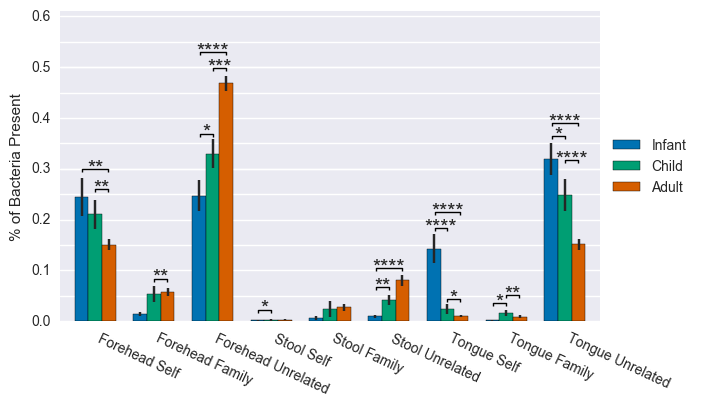

In [50]:
f = plt.figure(figsize=[8., 4.])
# results_age_site_specificity.transpose().plot(kind="bar", ylim=(0,.5001), color=precolors+["gray"], yerr=results_age_site_specificity_se.transpose(), rot=365-30, width=.7, ax=f.gca(), edgecolor="black")
results_age_site_specificity.transpose().plot(kind="bar", ylim=(0,.5001), color=sns.color_palette('colorblind'),
                                              yerr=results_age_site_specificity_se.transpose(), rot=365-30, width=.7,
                                              ax=f.gca(), edgecolor="black")
plt.xticks(ha="left")
plt.grid(False)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.grid(True, which="both")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.ylabel("% of Bacteria Present")
plt.ylim(0,.61)

horiz_offset = .22
# Self Skin sig bars
self_skin_center = 0
significance_bar(self_skin_center, self_skin_center+horiz_offset, results_age_site_specificity.loc['Child', 'Forehead Self']+.05, "**")
significance_bar(self_skin_center-horiz_offset, self_skin_center+horiz_offset, .3, "**")
# Family Skin sig bars
family_skin_center = 1
significance_bar(family_skin_center, family_skin_center+horiz_offset, results_age_site_specificity.loc['Child', 'Forehead Family']+.03, "**")
# Unrelated Skin sig bars
Unrelated_skin_center = 2
significance_bar(Unrelated_skin_center-horiz_offset, Unrelated_skin_center, results_age_site_specificity.loc['Child', 'Forehead Unrelated']+.04, "*")
significance_bar(Unrelated_skin_center, Unrelated_skin_center+horiz_offset, results_age_site_specificity.loc['Adult', 'Forehead Unrelated']+.03, "***")
significance_bar(Unrelated_skin_center-horiz_offset, Unrelated_skin_center+horiz_offset, .53, "****")
# Self Stool sig bars
self_stool_center = 3
significance_bar(self_stool_center-horiz_offset, self_stool_center, results_age_site_specificity.loc['Child', 'Stool Self']+.02, "*")
# Family stool sig bars
family_stool_center = 4
# Unrelated stool sig bars
Unrelated_stool_center = 5
significance_bar(Unrelated_stool_center-horiz_offset, Unrelated_stool_center, results_age_site_specificity.loc['Child', 'Stool Unrelated']+.025, "**")
significance_bar(Unrelated_stool_center-horiz_offset, Unrelated_stool_center+horiz_offset, .105, "****")
# Self Tongue sig bars
self_tongue_center = 6
significance_bar(self_tongue_center-horiz_offset, self_tongue_center, results_age_site_specificity.loc['Infant', 'Tongue Self']+.04, "****")
significance_bar(self_tongue_center, self_tongue_center+horiz_offset, results_age_site_specificity.loc['Child', 'Tongue Self']+.02, "*")
significance_bar(self_tongue_center-horiz_offset, self_tongue_center+horiz_offset, .215, "****")
# Family Tongue sig bars
family_tongue_center = 7
significance_bar(family_tongue_center-horiz_offset, family_tongue_center, results_age_site_specificity.loc['Child', 'Tongue Family']+.02, "*")
significance_bar(family_tongue_center, family_tongue_center+horiz_offset, results_age_site_specificity.loc['Child', 'Tongue Family']+.035, "**")
# Unrelated Tongue sig bars
Unrelated_tongue_center = 8
significance_bar(Unrelated_tongue_center-horiz_offset, Unrelated_tongue_center, results_age_site_specificity.loc['Infant', 'Tongue Unrelated']+.045, "*")
significance_bar(Unrelated_tongue_center, Unrelated_tongue_center+horiz_offset, results_age_site_specificity.loc['Child', 'Tongue Unrelated']+.07, "****")
significance_bar(Unrelated_tongue_center-horiz_offset, Unrelated_tongue_center+horiz_offset, .39, "****")

plt.savefig('figures/fig4C.png', dpi=500, bbox_inches="tight")

Again. Need to calculate stats for significance bars.

In [51]:
results_age_site_specificity = results_site_specificity.groupby(subject_ages)
print "Self Skin:"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Self"],
                                             results_age_site_specificity.get_group('Child')["Forehead Self"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Forehead Self"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Self"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Self"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Self"]).pvalue
print "Family Skin"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Family"],
                                             results_age_site_specificity.get_group('Child')["Forehead Family"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Forehead Family"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Family"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Family"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Family"]).pvalue
print "Unrelated Skin"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Unrelated"],
                                             results_age_site_specificity.get_group('Child')["Forehead Unrelated"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Forehead Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Unrelated"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Forehead Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Forehead Unrelated"]).pvalue
print

print "Self Stool"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Self"],
                                             results_age_site_specificity.get_group('Child')["Stool Self"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Stool Self"],
                                            results_age_site_specificity.get_group('Adult')["Stool Self"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Self"],
                                            results_age_site_specificity.get_group('Adult')["Stool Self"]).pvalue
print "Family Stool"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Family"],
                                             results_age_site_specificity.get_group('Child')["Stool Family"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Stool Family"],
                                            results_age_site_specificity.get_group('Adult')["Stool Family"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Family"],
                                            results_age_site_specificity.get_group('Adult')["Stool Family"]).pvalue
print "Unrelated Stool"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Unrelated"],
                                             results_age_site_specificity.get_group('Child')["Stool Unrelated"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Stool Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Stool Unrelated"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Stool Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Stool Unrelated"]).pvalue
print

print "Self Tongue"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Self"],
                                             results_age_site_specificity.get_group('Child')["Tongue Self"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Tongue Self"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Self"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Self"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Self"]).pvalue
print "Family Tongue"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Family"],
                                             results_age_site_specificity.get_group('Child')["Tongue Family"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Tongue Family"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Family"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Family"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Family"]).pvalue
print "Unrelated Tongue"
print "Infant -> Child: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Unrelated"],
                                             results_age_site_specificity.get_group('Child')["Tongue Unrelated"]).pvalue
print "Child -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Child')["Tongue Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Unrelated"]).pvalue
print "Infant -> Adult: %.2e" % mannwhitneyu(results_age_site_specificity.get_group('Infant')["Tongue Unrelated"],
                                            results_age_site_specificity.get_group('Adult')["Tongue Unrelated"]).pvalue

Self Skin:
Infant -> Child: 3.23e-01
Child -> Adult: 9.04e-03
Infant -> Adult: 2.33e-03
Family Skin
Infant -> Child: 9.99e-03
Child -> Adult: 1.05e-01
Infant -> Adult: 9.21e-02
Unrelated Skin
Infant -> Child: 3.14e-02
Child -> Adult: 1.10e-04
Infant -> Adult: 4.56e-08

Self Stool
Infant -> Child: 3.91e-02
Child -> Adult: 9.31e-02
Infant -> Adult: 1.81e-01
Family Stool
Infant -> Child: 3.22e-01
Child -> Adult: 3.82e-01
Infant -> Adult: 1.80e-01
Unrelated Stool
Infant -> Child: 1.54e-03
Child -> Adult: 2.34e-01
Infant -> Adult: 1.50e-06

Self Tongue
Infant -> Child: 1.22e-05
Child -> Adult: 3.72e-02
Infant -> Adult: 7.17e-13
Family Tongue
Infant -> Child: 2.69e-02
Child -> Adult: 3.67e-03
Infant -> Adult: 3.64e-01
Unrelated Tongue
Infant -> Child: 3.38e-02
Child -> Adult: 2.30e-04
Infant -> Adult: 3.27e-07


Here are all the stats.

## Gender and Parental Status Influences Source of Bacteria on Hands

Other possible effects on bacterial composition could be gender and parental status. These were investigated by partitioning our data set and looking for significant differences.

### Gender

We first looked for significant differences in gender.

In [52]:
subject_sex = np.array([meta.loc[i, 'sex'].title() for i in results.index])
results_sex_site = results_site.groupby(subject_sex)
display(results_sex_site.mean())

,Forehead,Stool,Tongue,Unknown
Female,0.601159,0.107008,0.249526,0.042308
Male,0.696409,0.082236,0.185800,0.035555


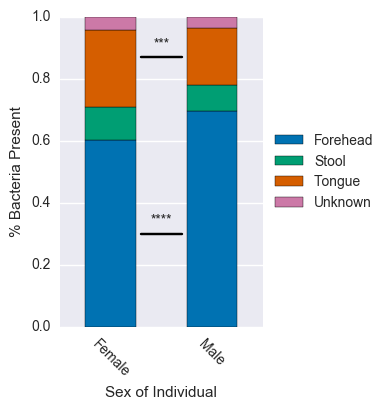

In [53]:
f = plt.figure(figsize=[3., 4.])
# results_sex_site.mean().plot(kind="bar", ylim=(0,1), stacked=True, color=precolors+['0'], rot=360-45, ax=f.gca(), edgecolor='black')
results_sex_site.mean().plot(kind="bar", ylim=(0,1), stacked=True, color=colors, rot=360-45, ax=f.gca(), edgecolor='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.plot([.3,.7],[.3, .3], color='black')
plt.text(.5, .33, '****', horizontalalignment='center')
plt.plot([.3, .7], [.87, .87], color='black')
plt.text(.5, .9, '***', horizontalalignment='center')
plt.ylabel("% Bacteria Present")
plt.xlabel("Sex of Individual")
plt.savefig("figures/fig5A.png", dpi=500, bbox_inches='tight')

So we can see that there is a significant difference in tongue and skin amounts on palms. Let's calculate some stats to show this.

In [54]:
print "Skin: %.2e" % mannwhitneyu(results_sex_site.get_group('Female')["Forehead"],
                                  results_sex_site.get_group('Male')["Forehead"]).pvalue
print "Stool: %.2e" % mannwhitneyu(results_sex_site.get_group('Female')["Stool"],
                                   results_sex_site.get_group('Male')["Stool"]).pvalue
print "Tongue: %.2e" % mannwhitneyu(results_sex_site.get_group('Female')["Tongue"],
                                    results_sex_site.get_group('Male')["Tongue"]).pvalue
print "Unknown: %.2e" % mannwhitneyu(results_sex_site.get_group('Female')["Unknown"],
                                    results_sex_site.get_group('Male')["Unknown"]).pvalue

Skin: 1.21e-05
Stool: 2.60e-01
Tongue: 3.81e-03
Unknown: 6.92e-02


So as shown in the plot above the only significant results are in the skin and tongue.

Now let's see if this is an affect of a gender imbalance across ages. So we will break this up to all age groups and see what we see.

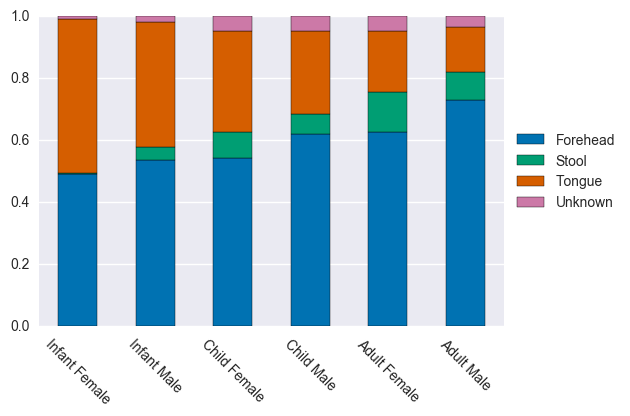

In [55]:
results_age_sex_site = results_site.groupby([' '.join(i) for i in zip(subject_ages, subject_sex)])
new_order = ['Infant Female', 'Infant Male', 'Child Female', 'Child Male', 'Adult Female', 'Adult Male']
# results_age_sex_site.mean().reindex(new_order).plot(kind="bar", ylim=(0,1), stacked=True, color=precolors+['0'], rot=360-45, edgecolor = 'black')
results_age_sex_site.mean().reindex(new_order).plot(kind="bar", ylim=(0,1), stacked=True, color=colors, rot=360-45, edgecolor = 'black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)

So visually there appears to be some differences. Let's find out.

In [56]:
print "Infant:"
print "Skin: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Infant Female')["Forehead"],
                                    results_age_sex_site.get_group('Infant Male')["Forehead"]).pvalue
print "Stool: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Infant Female')["Stool"],
                                    results_age_sex_site.get_group('Infant Male')["Stool"]).pvalue
print "Tongue: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Infant Female')["Tongue"],
                                    results_age_sex_site.get_group('Infant Male')["Tongue"]).pvalue
print "Unknown: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Infant Female')["Unknown"],
                                    results_age_sex_site.get_group('Infant Male')["Unknown"]).pvalue

print
print "Child:"
print "Skin: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Child Female')["Forehead"],
                                   results_age_sex_site.get_group('Child Male')["Forehead"]).pvalue
print "Stool: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Child Female')["Stool"],
                                   results_age_sex_site.get_group('Child Male')["Stool"]).pvalue
print "Tongue: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Child Female')["Tongue"],
                                   results_age_sex_site.get_group('Child Male')["Tongue"]).pvalue
print "Unknown: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Child Female')["Unknown"],
                                   results_age_sex_site.get_group('Child Male')["Unknown"]).pvalue
print
print "Adult:"
print "Skin: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Adult Female')["Forehead"],
                                   results_age_sex_site.get_group('Adult Male')["Forehead"]).pvalue
print "Stool: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Adult Female')["Stool"],
                                   results_age_sex_site.get_group('Adult Male')["Stool"]).pvalue
print "Tongue: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Adult Female')["Tongue"],
                                   results_age_sex_site.get_group('Adult Male')["Tongue"]).pvalue
print "Unknown: %.2e" % mannwhitneyu(results_age_sex_site.get_group('Adult Female')["Unknown"],
                                   results_age_sex_site.get_group('Adult Male')["Tongue"]).pvalue

Infant:
Skin: 2.72e-01
Stool: 1.84e-04
Tongue: 1.37e-01
Unknown: 6.44e-02

Child:
Skin: 1.15e-01
Stool: 4.39e-01
Tongue: 2.69e-01
Unknown: 4.94e-01

Adult:
Skin: 6.34e-06
Stool: 1.68e-02
Tongue: 3.89e-03
Unknown: 1.54e-07


And here are the stats. In infants the only significant differences between males and females is in stool where male infants have more. Children have no differences and all sites are significantly different in adults.

### Parent Status in Adults

Next we wanted to break up our adults into parents and nonparents in order to test for differences.

In [57]:
results_adults_site = results_site.loc[subject_ages=='Adult']
is_parent = ['Parent' if meta.loc[i, 'family_relationship'].split()[0] in ['mother', 'father'] else 'Nonparent' for i in results_adults_site.index]
results_adults_parent_site = results_adults_site.groupby(is_parent)
display(results_adults_parent_site.mean())

,Forehead,Stool,Tongue,Unknown
Nonparent,0.679942,0.119917,0.149967,0.050174
Parent,0.672431,0.096475,0.201951,0.029144


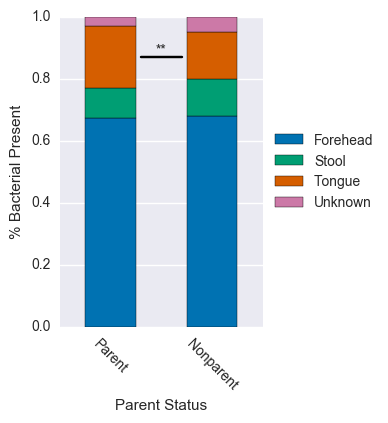

In [58]:
f = plt.figure(figsize=[3., 4.])
# results_adults_parent_site.mean().reindex(['Parent', 'Nonparent']).plot(kind="bar", ylim=(0,1), stacked=True, color=precolors+['0'],
#                                                                         rot=360-45, ax=f.gca(), edgecolor='black')
results_adults_parent_site.mean().reindex(['Parent', 'Nonparent']).plot(kind="bar", ylim=(0,1), stacked=True, color=colors,
                                                                        rot=360-45, ax=f.gca(), edgecolor='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.plot([.3, .7], [.87, .87], color='black')
plt.text(.5, .88, '**', horizontalalignment='center')
plt.xlabel("Parent Status")
plt.ylabel("% Bacterial Present")
plt.savefig("figures/fig5B.png", dpi=500, bbox_inches='tight')

So we have our barchart let's do our stats.

In [59]:
print "Skin: %.2e" % mannwhitneyu(results_adults_parent_site.get_group('Parent')["Forehead"],
                                  results_adults_parent_site.get_group('Nonparent')["Forehead"]).pvalue
print "Stool: %.2e" % mannwhitneyu(results_adults_parent_site.get_group('Parent')["Stool"],
                                   results_adults_parent_site.get_group('Nonparent')["Stool"]).pvalue
print "Tongue: %.2e" % mannwhitneyu(results_adults_parent_site.get_group('Parent')["Tongue"],
                                    results_adults_parent_site.get_group('Nonparent')["Tongue"]).pvalue
print "Unknown: %.2e" % mannwhitneyu(results_adults_parent_site.get_group('Parent')["Unknown"],
                                     results_adults_parent_site.get_group('Nonparent')["Unknown"]).pvalue

Skin: 2.94e-01
Stool: 1.90e-01
Tongue: 7.08e-03
Unknown: 3.03e-01


So the only significant difference between parents and nonparents is the amount of tongue on palms.

### Gender and Parent status

So now let's combine the two above categories and do an analysis.

In [60]:
gender_adult = [meta.loc[i, 'sex'].title() for i in results_adults_site.index]
parent_genders = [' '.join(i) for i in zip(gender_adult, is_parent)]
results_adult_parent_gender_site = results_adults_site.groupby(parent_genders)
display(results_adult_parent_gender_site.mean())

,Forehead,Stool,Tongue,Unknown
Female Nonparent,0.630671,0.151962,0.159919,0.057449
Female Parent,0.623634,0.088070,0.256700,0.031595
Male Nonparent,0.740944,0.080243,0.137644,0.041168
Male Parent,0.718113,0.104343,0.150696,0.026849


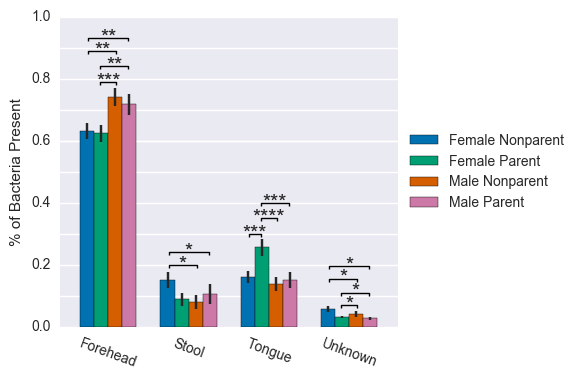

In [61]:
f = plt.figure(figsize=[5, 4])
# results_adult_parent_gender_site.mean().transpose().plot(kind="bar", ylim=(0,1), color=precolors+['0'],
#                                                          rot=360-20, ax=f.gca(), width=.7, edgecolor='black',
#                                                          yerr=results_adult_parent_gender_site.sem().transpose())
results_adult_parent_gender_site.mean().transpose().plot(kind="bar", ylim=(0,1), color=colors,
                                                         rot=360-20, ax=f.gca(), width=.7, edgecolor='black',
                                                         yerr=results_adult_parent_gender_site.sem().transpose())
plt.xticks(ha='center')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.ylabel("% of Bacteria Present")
plt.grid(False)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.grid(True, which="both")

horiz_offset = 1/14

# skin comparisons
skin_center = 0
significance_bar(skin_center-.1, skin_center+.1, .79, "***")
significance_bar(skin_center-.1, skin_center+.25, .84, "**")
significance_bar(skin_center-.25, skin_center+.1, .89, "**")
significance_bar(skin_center-.25, skin_center+.25, .93, "**")
# stool comparisons
stool_center = 1
significance_bar(stool_center-.25, stool_center+.1, .2, "*")
significance_bar(stool_center-.25, stool_center+.25, .24, "*")
# tongue comparisons
tongue_center = 2
significance_bar(tongue_center-.25, tongue_center-.1, .3, "***")
significance_bar(tongue_center-.1, tongue_center+.1, .35, "****")
significance_bar(tongue_center-.1, tongue_center+.25, .4, "***")
# unknown comparisons
unknown_center = 3
significance_bar(unknown_center-.1, unknown_center+.1, .07, "*")
significance_bar(unknown_center-.1, unknown_center+.25, .11, "*")
significance_bar(unknown_center-.25, unknown_center+.1, .155, "*")
significance_bar(unknown_center-.25, unknown_center+.25, .195, "*")

plt.savefig('figures/fig5B', dpi=500, bbox_inches="tight")

Key: \*: p<.05 \*\*: p<.01 \*\*\*: p<.001 \*\*\*\*: p<.0001

In [62]:
n_m = 'Male Nonparent'
n_f = 'Female Nonparent'
p_m = 'Male Parent'
p_f = 'Female Parent'

print "Skin"
print "nf->pf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_f)["Forehead"],
                           results_adult_parent_gender_site.get_group(p_f)["Forehead"]).pvalue
print "pf->nm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(p_f)["Forehead"]).pvalue
print "nm->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(p_m)["Forehead"]).pvalue
print "nm->nf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(n_f)["Forehead"]).pvalue
print "pf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(p_f)["Forehead"]).pvalue
print "nf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(n_f)["Forehead"]).pvalue
print ""
print "Stool"
print "nf->pf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_f)["Stool"],
                           results_adult_parent_gender_site.get_group(p_f)["Stool"]).pvalue
print "pf->nm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Stool"],
                           results_adult_parent_gender_site.get_group(p_f)["Stool"]).pvalue
print "nm->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Stool"],
                           results_adult_parent_gender_site.get_group(p_m)["Stool"]).pvalue
print "nm->nf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Stool"],
                           results_adult_parent_gender_site.get_group(n_f)["Stool"]).pvalue
print "pf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Stool"],
                           results_adult_parent_gender_site.get_group(p_f)["Stool"]).pvalue
print "nf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Stool"],
                           results_adult_parent_gender_site.get_group(n_f)["Stool"]).pvalue
print ""
print "Tongue"
print "nf->pf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_f)["Tongue"],
                           results_adult_parent_gender_site.get_group(p_f)["Tongue"]).pvalue
print "pf->nm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Tongue"],
                           results_adult_parent_gender_site.get_group(p_f)["Tongue"]).pvalue
print "nm->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Tongue"],
                           results_adult_parent_gender_site.get_group(p_m)["Tongue"]).pvalue
print "nm->nf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Tongue"],
                           results_adult_parent_gender_site.get_group(n_f)["Tongue"]).pvalue
print "pf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Tongue"],
                           results_adult_parent_gender_site.get_group(p_f)["Tongue"]).pvalue
print "nf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Tongue"],
                           results_adult_parent_gender_site.get_group(n_f)["Tongue"]).pvalue
print ""
print "Unknown"
print "nf->pf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_f)["Unknown"],
                           results_adult_parent_gender_site.get_group(p_f)["Unknown"]).pvalue
print "pf->nm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Unknown"],
                           results_adult_parent_gender_site.get_group(p_f)["Unknown"]).pvalue
print "nm->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Unknown"],
                           results_adult_parent_gender_site.get_group(p_m)["Unknown"]).pvalue
print "nm->nf", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Unknown"],
                           results_adult_parent_gender_site.get_group(n_f)["Unknown"]).pvalue
print "pf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Unknown"],
                           results_adult_parent_gender_site.get_group(p_f)["Unknown"]).pvalue
print "nf->pm", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Unknown"],
                           results_adult_parent_gender_site.get_group(n_f)["Unknown"]).pvalue

Skin
nf->pf 0.270772654358
pf->nm 0.000213119469876
nm->pm 0.231427433687
nm->nf 0.000424626809153
pf->pm 0.00318574880241
nf->pm 0.00387065993008

Stool
nf->pf 0.0957297912859
pf->nm 0.217136107614
nm->pm 0.417433360193
nm->nf 0.0103908394224
pf->pm 0.345647956636
nf->pm 0.0361935983054

Tongue
nf->pf 0.000708874342739
pf->nm 3.02593466295e-05
nm->pm 0.336159141432
nm->nf 0.155803201629
pf->pm 0.000714691604431
nf->pm 0.345476698915

Unknown
nf->pf 0.259375332522
pf->nm 0.0374821247504
nm->pm 0.472216432826
nm->nf 0.0131759878641
pf->pm 0.027954125526
nf->pm 0.0143949322572


In [63]:
n_m = 'Male Nonparent'
n_f = 'Female Nonparent'
p_m = 'Male Parent'
p_f = 'Female Parent'

print "Gender effect in Nonparents"
print "Skin", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(n_f)["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Stool"],
                            results_adult_parent_gender_site.get_group(n_f)["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Tongue"],
                             results_adult_parent_gender_site.get_group(n_f)["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_adult_parent_gender_site.get_group(n_m)["Unknown"],
                              results_adult_parent_gender_site.get_group(n_f)["Unknown"]).pvalue
print ""
print "Gender effect in Parents"
print "Skin", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(p_f)["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Stool"],
                            results_adult_parent_gender_site.get_group(p_f)["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Tongue"],
                             results_adult_parent_gender_site.get_group(p_f)["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Unknown"],
                              results_adult_parent_gender_site.get_group(p_f)["Unknown"]).pvalue
print ""
print "Parent effect in Males"
print "Skin", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Forehead"],
                           results_adult_parent_gender_site.get_group(n_m)["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Stool"],
                            results_adult_parent_gender_site.get_group(n_m)["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Tongue"],
                             results_adult_parent_gender_site.get_group(n_m)["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_adult_parent_gender_site.get_group(p_m)["Unknown"],
                              results_adult_parent_gender_site.get_group(n_m)["Unknown"]).pvalue
print ""
print "Parent effect in Females"
print "Skin", mannwhitneyu(results_adult_parent_gender_site.get_group(p_f)["Forehead"],
                           results_adult_parent_gender_site.get_group(n_f)["Forehead"]).pvalue
print "Stool", mannwhitneyu(results_adult_parent_gender_site.get_group(p_f)["Stool"],
                            results_adult_parent_gender_site.get_group(n_f)["Stool"]).pvalue
print "Tongue", mannwhitneyu(results_adult_parent_gender_site.get_group(p_f)["Tongue"],
                             results_adult_parent_gender_site.get_group(n_f)["Tongue"]).pvalue
print "Unknown", mannwhitneyu(results_adult_parent_gender_site.get_group(p_f)["Unknown"],
                              results_adult_parent_gender_site.get_group(n_f)["Unknown"]).pvalue

Gender effect in Nonparents
Skin 0.000424626809153
Stool 0.0103908394224
Tongue 0.155803201629
Unknown 0.0131759878641

Gender effect in Parents
Skin 0.00318574880241
Stool 0.345647956636
Tongue 0.000714691604431
Unknown 0.027954125526

Parent effect in Males
Skin 0.231427433687
Stool 0.417433360193
Tongue 0.336159141432
Unknown 0.472216432826

Parent effect in Females
Skin 0.270772654358
Stool 0.0957297912859
Tongue 0.000708874342739
Unknown 0.259375332522


So we see that both gender and parent status have a comingling effect on palm bacteria composition in terms of origin site. Interestingly while parenthood has no affect on palm bacteria composition in males it affects the amount of tongue bacteria on palms in females. Gender has an affect on both parents and nonparents with skin being more abundant in males and unknown bacteria being more abundant in females in both parents and nonparents.  In nonparents females had significantly more stool than males and in parents and in parents females had significantly more tongue bacteria than males.

### Age of origin of bacteria on palms

Finally in our parent vs. nonparent group we wanted to test for differences in the age of origin of bacteria.

In [64]:
source_ages = [meta.loc[i, 'age_group'].title() for i in results.columns if i != 'Unknown'] + ['Unknown']
results_age = results.groupby(source_ages, axis=1).sum()
display(results_age.groupby(meta.age_group).mean())
display(results_age.groupby(meta.age_group).median())
results_adults_age = results_age.loc[[i for i in results_age.index if meta.loc[i, 'age_group'] == 'adult']]
is_parent = ['Parent' if meta.loc[i, 'family_relationship'].split()[0] in ['mother', 'father'] else 'Nonparent' for i in results_adults_age.index]
results_adults_parent_age = results_adults_age.groupby([is_parent])
display(results_adults_parent_age.median())
display(results_adults_parent_age.mean())

,Adult,Child,Infant,Unknown
age_group,,,,
adult,0.754197,0.064338,0.139539,0.041925
child,0.433839,0.379953,0.138987,0.047221
infant,0.253886,0.097929,0.637040,0.011146


,Adult,Child,Infant,Unknown
age_group,,,,
adult,0.83850,0.03620,0.0380,0.02310
child,0.39805,0.38755,0.0662,0.03105
infant,0.23130,0.06070,0.6764,0.00050


,Adult,Child,Infant,Unknown
Nonparent,0.8824,0.0327,0.0201,0.0203
Parent,0.7013,0.0502,0.1770,0.0239


,Adult,Child,Infant,Unknown
Nonparent,0.810387,0.052848,0.086591,0.050174
Parent,0.667135,0.082143,0.221578,0.029144


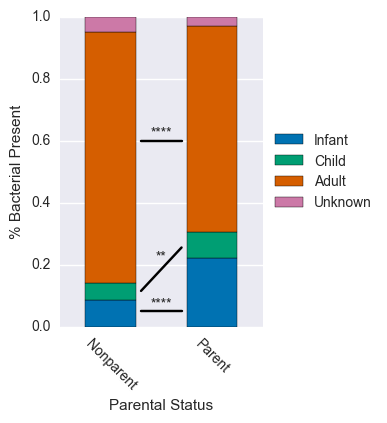

In [65]:
f = plt.figure(figsize=[3., 4.])
# results_adults_parent_age.mean()[['Infant', 'Child', 'Adult', 'Unknown']].plot(kind="bar", ylim=(0,1), stacked=True, color=precolors+['0'], rot=360-45, ax=f.gca(), edgecolor='black')
results_adults_parent_age.mean()[['Infant', 'Child', 'Adult', 'Unknown']].plot(kind="bar", ylim=(0,1), stacked=True, color=colors, rot=360-45, ax=f.gca(), edgecolor='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.plot([.3, .7], [.05, .05], color='black')
plt.text(.5, .06, '****', horizontalalignment='center')
plt.plot([.3, .7], [.115, .255], color='black')
plt.text(.5, .21, '**', horizontalalignment='center')
plt.plot([.3, .7], [.6, .6], color='black')
plt.text(.5, .61, '****', horizontalalignment='center')
plt.ylabel("% Bacterial Present")
plt.xlabel("Parental Status")
plt.savefig("figures/fig5C.png", dpi=500, bbox_inches='tight')

In [66]:
print "Infant: %.2e" % mannwhitneyu(results_adults_parent_age.get_group('Parent')["Infant"],
                                  results_adults_parent_age.get_group('Nonparent')["Infant"]).pvalue
print "Child: %.2e" % mannwhitneyu(results_adults_parent_age.get_group('Parent')["Child"],
                                   results_adults_parent_age.get_group('Nonparent')["Child"]).pvalue
print "Adult: %.2e" % mannwhitneyu(results_adults_parent_age.get_group('Parent')["Adult"],
                                    results_adults_parent_age.get_group('Nonparent')["Adult"]).pvalue

Infant: 1.02e-08
Child: 2.31e-03
Adult: 1.44e-07


So here all are significant. Nonparents have more adult originating bacteria while nonparents have more from infants and children.

#### Combining infants and children

In [67]:
grouped_kids = {'Infant': 'Juvenile', 'Child': 'Juvenile', 'Adult': 'Adult', 'Unknown': 'Unknown'}
source_ages2 = [grouped_kids[i] for i in source_ages]
results_age2 = results.groupby(source_ages2, axis=1).sum()
display(results_age2.groupby(meta.age_group).mean())
display(results_age2.groupby(meta.age_group).median())
results_adults_age2 = results_age2.loc[[i for i in results_age.index if meta.loc[i, 'age_group'] == 'adult']]
is_parent = ['Parent' if meta.loc[i, 'family_relationship'].split()[0] in ['mother', 'father'] else 'Nonparent' for i in results_adults_age2.index]
results_adults_parent_age2 = results_adults_age2.groupby([is_parent])
display(results_adults_parent_age2.median())
display(results_adults_parent_age2.mean())

,Adult,Juvenile,Unknown
age_group,,,
adult,0.754197,0.203877,0.041925
child,0.433839,0.518939,0.047221
infant,0.253886,0.734969,0.011146


,Adult,Juvenile,Unknown
age_group,,,
adult,0.83850,0.11745,0.02310
child,0.39805,0.57255,0.03105
infant,0.23130,0.76720,0.00050


,Adult,Juvenile,Unknown
Nonparent,0.8824,0.0638,0.0203
Parent,0.7013,0.2654,0.0239


,Adult,Juvenile,Unknown
Nonparent,0.810387,0.139439,0.050174
Parent,0.667135,0.303721,0.029144


In [68]:
print "Juvenile: %.2e" % mannwhitneyu(results_adults_parent_age2.get_group('Parent')["Juvenile"],
                                  results_adults_parent_age2.get_group('Nonparent')["Juvenile"]).pvalue
print "Adult: %.2e" % mannwhitneyu(results_adults_parent_age2.get_group('Parent')["Adult"],
                                    results_adults_parent_age2.get_group('Nonparent')["Adult"]).pvalue

Juvenile: 2.94e-10
Adult: 1.44e-07
